# IQC 2024/25 - Practical

## Setup

Install a clean Python environment and required modules: 

```bash
python -m venv .venv
.venv/bin/pip install pennylane matplotlib
```

Use `.venv/bin/python` as the Python kernel. 

Run imports below to test your environment. 

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pennylane as pl

## Part 1 – Classical Random Walk

The random walk is a procedure, where at every time step an imaginary particle at given position has a random chance to move to next or previous position. The simplest example uses an unbiased coin to determine which direction to take. The goal of this exercise is for you to familiarise yourselves with the classical case before we move on to the quantum version. 

A very simple implementation of the random walk is given below. It simulates the position of the particle after *n* steps. Repeated calls can sample from different end positions. The probability $p$ can be modified for a biased coin. 

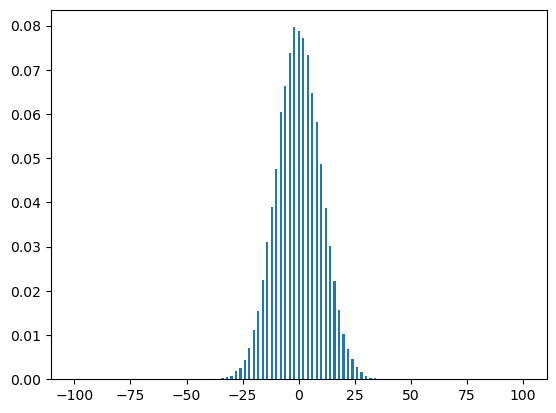

In [ ]:
def random_walk(T, start = 0, p = .5):
  # Create a random sequence of 1 and -1 values. 
  steps = np.random.choice([1, -1], T, p = [p, 1 - p])
  return np.sum(steps)

N_STEPS = 100
N_SAMPLES = 100000
walks = [random_walk(N_STEPS) for _ in range(N_SAMPLES)]
plt.hist(walks, bins = 2 * N_STEPS + 1, density = True, range = (-N_STEPS - .5, N_STEPS + .5))
plt.show()

The walk above can reach any point in space. As in practice the size of the quantum register is finite, it is useful to add **boundary conditions** to the problem. In such a case, the particle is contained in a box of $n$ positions, from $0$ to $n - 1$, and start at position $\lfloor n / 2 \rfloor$. If the position exceeds the range of the box, the particle moves to the other side, i.e. from $0$ to $n - 1$, and from $n - 1$ to $0$. This can be visualised as if the particle was moving on a ring with first and last position connected. 

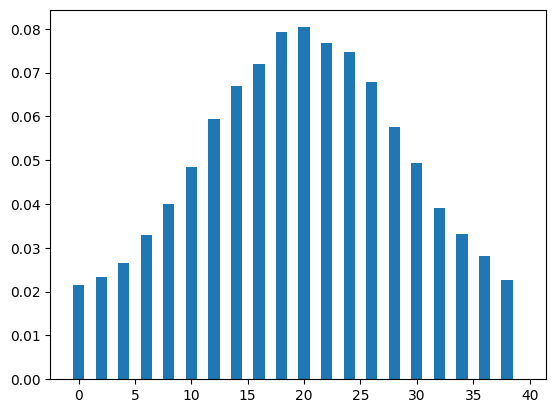

In [ ]:
def random_walk_bc(n, max, start = None, p = .5):
  # By default start in the middle of the box. 
  if start is None: 
    start = max // 2
  
  # Create a random sequence of 1 and -1 values. 
  steps = np.random.choice([1, -1], n, p = [p, 1 - p])
  return (start + np.sum(steps)) % max

N_STEPS = 100
N_STATES = 40
N_SAMPLES = 100000
walks = [random_walk_bc(N_STEPS, N_STATES) for _ in range(N_SAMPLES)]
plt.hist(walks, bins = N_STATES, density = True, range = (-.5, N_STATES - .5))
plt.show()

The functions above simulate the random walk one by one. However, there exists a different approach, which allows calculating all probabilities at once. The idea is to represent the probabilities of ending up in a given position with an $n$ element vector, where the $k$-th element corresponds to the probability of finishing in position $k$. We initialise the starting state $\vec{p_0}$ with the basis vector corresponding to the starting position, such that the only non-zero element is at position $k$. E.g. for 4 elements, starting in position 2 looks as follows: 

$$
\vec{p}_0 = \vec{e}_2 = 
\begin{pmatrix}
  0 \\ 0 \\ 1 \\ 0
\end{pmatrix}$$

Now, we can represent the transitions at each time step with a matrix $M$. For any state $\vec{p}_k$, where $k$ corresponds to current position, there is a 50% chance to move to $k-1$ and 50% to move to $k+1$. Therefore, we need to create a matrix $M$ that implements this operation. To do this, we can decompose this matrix into a sum of permutations, such that $M = \frac{1}{2} P_+ + \frac{1}{2} P_-$, where $P_+$ corresponds to the upwards shift $\vec{e}_i \rightarrow \vec{e}_{(i + 1)\ \% \ n}$ and $P_-$ to the downwards shift $\vec{e}_i \rightarrow \vec{e}_{(i - 1)\ \% \ n}$. 

For example, for a box with 4 elements, the matrix is going to be the following: 

$$
M = \frac{1}{2} 
\begin{pmatrix}
  0 & 0 & 0 & 1 \\
  1 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 \\
  0 & 0 & 1 & 0
\end{pmatrix} 
+ \frac{1}{2} 
\begin{pmatrix}
  0 & 1 & 0 & 0 \\
  0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 1 \\
  1 & 0 & 0 & 0
\end{pmatrix}
= \frac{1}{2} 
\begin{pmatrix}
  0 & 1 & 0 & 1 \\
  1 & 0 & 1 & 0 \\
  0 & 1 & 0 & 1 \\
  1 & 0 & 1 & 0
\end{pmatrix}
$$

To calculate the final probabilities for starting state $\vec{v}_k$ and $T$ time steps, we can apply the following formula: 

$$\vec{p}_T = M^T \vec{p}_0$$

### Exercise 1 [10 marks]

Convince yourself why the formulation above works. Then, implement the following snippet of code. 
1. `transition_matrix(n, p)` implements the matrix $M$ for an arbitrary number of states $n$ and transition probability $p$ to the next state, and $1 - p$ to the previous state. *[2 marks]*
2. `random_walk_vec(n, T, start, p)` calculates the vector of probabilities $\vec{p}_T$, where $k$-th element in the vector gives the probability of ending up at the position $k$, given the starting state $\vec{p}_0$ with 1 at the starting position. *[4 marks]*
3. Finally, plot the results to check your implementation. For example, use the same parameters as in `random_walk_bc` above. Should the plots be exactly the same? Why or why not? *[4 marks]*

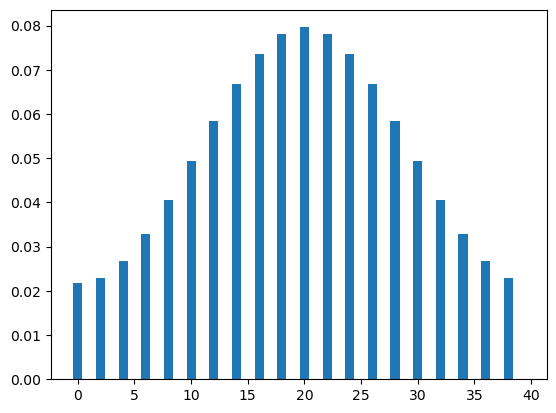

In [ ]:
def transition_matrix(n, p = .5):
  # Implementation here.
  # p_plus
  p_plus = np.eye(n)
  p_plus = np.roll(p_plus, 1, axis=0)

  # p_minus
  p_minus = np.eye(n)
  p_minus = np.roll(p_minus, -1, axis=0)

  # transition matrix m
  m = p * p_plus + (1 - p) * p_minus
  return m

def random_walk_vec(n, T, start = None, p = .5):
  if start is None:
    start = n // 2

  # Implementation here.
  # find m_T
  m = transition_matrix(n, p)
  m_T = np.linalg.matrix_power(m, T)

  # create vector p
  p = np.zeros(n, )
  p[start] = 1

  # find p_T
  p_T = np.dot(m_T, p)
  return p_T

N_STEPS = 100
N_STATES = 40
N_SAMPLES = 100000

# add all probabilities for each run and find average probability for each state
walks = np.zeros(N_STATES, )
for i in range(N_SAMPLES):
  p_T = random_walk_vec(N_STATES, N_STEPS)
  walks = walks + p_T

# plot bar chart
walks = walks / N_SAMPLES
states = np.arange(0, 40 ,1)
plt.bar(states, walks)
plt.show()


**Method explained**

To plot results we calculate the final probability vector after N_STEPS and repeat this N_SAMPLES times. The output of each run is added to the walks vector which stores the sum of all probabilities across all runs. Normalizing this vector by N_SAMPLES gives the average probabilities of the random walk ending each of the N_STATES positions. 

**Should the plots be the same?**

The plots should be the same as we have created the same classical random walk model but the method has changed. We instead use linear algebra to achieve the same goal. Both methods implement a random walk over N_STATES for N_STEPS, repeated N_SAMPLES times. The first method focuses on treating the position as a Bernoulli random variable via position shifts and finds the final positions for each walk after N_STEPS and creating a probability distribution of these final positions after N_SAMPLES final positions have been found. The linear algrebra method instead directly calculates the average probabilities of the random walk ending in each position after N_SAMPLES random walks. 

## Part 2 – Quantum Walk in 1D

Since we reformulated the random walk problem using linear algebra, it is interesting to see if there is an equivalent quantum circuit that could implement this. Unfortunately, the matrix $M$ is non-unitary, and we need to find a way to make it unitary, as these are the only valid evolutions in quantum computers. 

One of the approaches is to separate the actions of our imaginary particle moving up and down its current position. We could have a quantum register $\lvert \rho_0 \rangle$ of $N$ qubits representing $n = 2^N$ possible states, such that the probability of measuring a basis state $\lvert k \rangle$ corresponds to the probability of the particle ending up at position $k$. In other words, the element  $\lvert \langle k \vert \rho_T \rangle \rvert^2$ is equivalent to the $k$-th element of $\vec{p}_T$ defined in the previous section. 

Now, we can define unitary transition matrices for both next and previous state. Let 
$$\hat{U}_- \lvert k \rangle = \lvert (k - 1) \ \% \ n \rangle$$
$$\hat{U}_+ \lvert k \rangle = \lvert (k + 1) \ \% \ n \rangle$$
be those operators. You can prove that both are unitary. 

Let us think about how to implement the transition matrices. We can start with a simple example on 4 qubits, where $\lvert k \rangle \rightarrow \lvert k + 1 \rangle$. $\lvert k \rangle$ can be written down in the binary representation: 
$$\lvert k \rangle = \lvert \overline{k_3 k_2 k_1 k_0} \rangle = \lvert k_0 \rangle \lvert k_1 \rangle \lvert k_2 \rangle \lvert k_3 \rangle$$ 
If $k_0 = 0$, then it is increased to 1, and then the operation is finished. However, if $k_0 = 1$, then the addition is carried over to the next qubit. In both cases, $\lvert k_0' \rangle = \hat{X}\lvert k_0 \rangle$. However, in the second case, we also need to add 1 to $\lvert k_1 \rangle$, which means applying an $\hat{X}$ gate conditional on the first qubit being 0. This is then repeated recursively for the following qubits. 

*Note: all exercises below use little-endian ordering, where lower-index qubits represent smaller powers of two when reading the register.*

### Exercise 2 [15 marks]

Pennylane gives you access to controlled gates with an arbitrary number of control qubits, and either 0 or 1 as control values. Implement both $\hat{U}_+$ and $\hat{U}_-$ operators using controlled $\hat{X}$ gates. Then test and print your circuit. 

1. `mC0X(target)` should be a helper function that applies an $\hat{X}$ gate controlled by 0 values for all qubits below it (i.e. lower index). For example the gate created for `target = 2` may look as follows: *[3 marks]*
    ```
    # Q0: ────╭○──── #
    # Q1: ────├○──── #
    # Q2: ────╰X──── #
    # Q3: ────────── #
    # ...            #
    ```

2. `U_plus()` applies the next-state transition unitary to the entire register. You can use the helper gates here. *[2 marks]*
3. `U_minus()` applies the previous-state transition unitary to the entire register. You can use the helper gates here. Since the explanation above is only for the plus unitary, think about its relation to the minus unitary. Hint: consider unitarity. *[4 marks]*
4. Use Pennylane to draw both `U_plus` and `U_minus` circuits defined above. *[1 marks]*
5. `circuit()` represents a simple circuit to test the plus and minus gates. Feel free to do whatever you need here to verify that your gates are working correctly. How do you convert between Pennylane output and integer states? Are the boundary transitions between $\lvert 0 \rangle$ and $\lvert 2^N - 1 \rangle$ as expected? *[5 marks]*

In [189]:
N_WIRES = 8
dev = pl.device("default.qubit", wires = N_WIRES, shots = 100)

# Multi-controlled X gate.
def mC0X(target):
    # Implementation here.
    # find controls
    controls = np.arange(0, target, 1)

    # control values = 0's
    control_zeros = np.zeros(target, )

    # implement control not
    pl.MultiControlledX(wires=(*controls, target), control_values=control_zeros)
    return


# +1 transition unitary.
def U_plus():
    pl.PauliX(wires=0)
    for i in range(1, N_WIRES):
        mC0X(i)
    return

# -1 transition unitary.
def U_minus():
    # Implementation here.
    for i in range(1, N_WIRES):
        mC0X(N_WIRES - i)
    pl.PauliX(wires=0)
    return

# Draw the circuits here
print("U+")
print(pl.draw(U_plus)())
print("U-")
print(pl.draw(U_minus)())


@pl.qnode(dev)
# define circuit to implement U+, U- or both to check outputs
def circuit(input_state, unitary):
    # flip qubits for inputs which are 1
    states = list(enumerate(input_state))
    for i, bit in states:
        if bit == 1:
            pl.PauliX(wires=i)
    # implement circuit chosen
    if unitary == "U+":
        U_plus()
    if unitary == "U-":
        U_minus()
    if unitary == "U+U-":
        U_plus()
        U_minus()
    return pl.sample()

# function for going through each scenario to test circuit
def input_scenario(input_state, unitary):
    # initialise circuit
    circuit(input_state, unitary)
    res = circuit(input_state, unitary=unitary)
    # take one of the results and reverse to make binary
    single_res = res[0]
    res_bin = single_res[::-1]
    # use string to int conversion, base 2 to convert binary to integers
    res_int = int("".join(str(i) for i in res_bin), 2)
    in_int = int("".join(str(i) for i in input_state[::-1]), 2)
    print("Binary input : ", input_state[::-1])
    print("Integer input : ", in_int)
    print("Unitary chosen : ", unitary)
    print("Binary output : ", res_bin)
    print("Integer output : ", res_int)
    print("\n")

# reverse binary input - e.g. below is 7
input_1 = [1, 1, 1, 0, 0, 0, 0, 0]
# expected outcome = 8 for U+
input_scenario(input_1, "U+")
# expected outcome = 6 for U-
input_scenario(input_1, "U-")
# expected outcome = 7 for U+U-
input_scenario(input_1, "U+U-")

# boundary tests:
input_lower = [0, 0, 0, 0, 0, 0, 0, 0]
input_scenario(input_lower, "U-")
input_higher = [1, 1, 1, 1, 1, 1, 1, 1]
input_scenario(input_higher, "U+")



U+
0: ──X─╭○─╭○─╭○─╭○─╭○─╭○─╭○─┤  
1: ────╰X─├○─├○─├○─├○─├○─├○─┤  
2: ───────╰X─├○─├○─├○─├○─├○─┤  
3: ──────────╰X─├○─├○─├○─├○─┤  
4: ─────────────╰X─├○─├○─├○─┤  
5: ────────────────╰X─├○─├○─┤  
6: ───────────────────╰X─├○─┤  
7: ──────────────────────╰X─┤  
U-
0: ─╭○─╭○─╭○─╭○─╭○─╭○─╭○──X─┤  
1: ─├○─├○─├○─├○─├○─├○─╰X────┤  
2: ─├○─├○─├○─├○─├○─╰X───────┤  
3: ─├○─├○─├○─├○─╰X──────────┤  
4: ─├○─├○─├○─╰X─────────────┤  
5: ─├○─├○─╰X────────────────┤  
6: ─├○─╰X───────────────────┤  
7: ─╰X──────────────────────┤  
Binary input :  [0, 0, 0, 0, 0, 1, 1, 1]
Integer input :  7
Unitary chosen :  U+
Binary output :  [0 0 0 0 1 0 0 0]
Integer output :  8


Binary input :  [0, 0, 0, 0, 0, 1, 1, 1]
Integer input :  7
Unitary chosen :  U-
Binary output :  [0 0 0 0 0 1 1 0]
Integer output :  6


Binary input :  [0, 0, 0, 0, 0, 1, 1, 1]
Integer input :  7
Unitary chosen :  U+U-
Binary output :  [0 0 0 0 0 1 1 1]
Integer output :  7


Binary input :  [0, 0, 0, 0, 0, 0, 0, 0]
Integer input :  0
Unitar

**Method explained - Converting between pennylane output and integer states**

Above in the input scenario function I have converted the list into a string then and then converted this to find the integer state using int() at base 2.  

**Boundary transitions as expected?**

Yes the boundary transitions are as expected as seen within the boundary tests section of the code. Integer 255 with U+ goes back to 0 and integer state 0 with U- goes to 255.

We learnt how to move each the state either up or down, but how do we apply both according to given probabilities? The trick is to utilise an ancilla qubit to represent the superposition of $\lvert 0 \rangle$ and $\lvert 1 \rangle$ states. This qubit we can call the **coin qubit**, and it can be used as control to each of the operators above, so that both operations are applied at once, i.e. 
$$\hat{M} \lvert 0 \rangle \lvert k \rangle = \lvert 0 \rangle \lvert (k - 1) \ \% \ n \rangle$$
$$\hat{M} \lvert 1 \rangle \lvert k \rangle = \lvert 1 \rangle \lvert (k + 1) \ \% \ n \rangle$$

A **quantum walk** step then looks as follows: 

![image](walk-step.svg)

This is then repeated $T$ times for $T$ time steps. Importantly, the Hadamard gate is applied for every step. For now, the coin register is initialised to $\lvert 0 \rangle$. 

### Exercise 3 [15 marks]
Reimplement the -1 and +1 operators from exercise 2 conditional on the coin qubit. Use them to write a full quantum walk. Feel free to add helper functions similar to `mC0X` above. 

1. Write `CU_plus()` and `CU_minus()`, which are now controlled by the coin qubit. Be careful which control values to use. *[4 marks]*
2. Write `quantum_walk(T)`, which is a quantum walk with $T$ steps. The walk should start *in the middle state* (i.e. $\frac{1}{2} \cdot 2^N$). *[4 marks]*
3. Plot the histogram of your results, similar to the ones in part 1. Explain what is different about the classical and quantum case. Why do you think this is the case? What happens if you vary the number of time steps $T$? *[7 marks]*

Example circuit for two timesteps
coin: ──H─╭○─╭○─╭○─╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●─╭●─╭●─╭●──H─╭○─╭○─╭○─╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●─╭●─╭●─╭●─┤
   0: ────├○─├○─├○─├○─├○─├○─╰X─╰X─├○─├○─├○─├○─├○─├○────├○─├○─├○─├○─├○─├○─╰X─╰X─├○─├○─├○─├○─├○─├○─┤
   1: ────├○─├○─├○─├○─├○─╰X───────╰X─├○─├○─├○─├○─├○────├○─├○─├○─├○─├○─╰X───────╰X─├○─├○─├○─├○─├○─┤
   2: ────├○─├○─├○─├○─╰X─────────────╰X─├○─├○─├○─├○────├○─├○─├○─├○─╰X─────────────╰X─├○─├○─├○─├○─┤
   3: ────├○─├○─├○─╰X───────────────────╰X─├○─├○─├○────├○─├○─├○─╰X───────────────────╰X─├○─├○─├○─┤
   4: ────├○─├○─╰X─────────────────────────╰X─├○─├○────├○─├○─╰X─────────────────────────╰X─├○─├○─┤
   5: ────├○─╰X───────────────────────────────╰X─├○────├○─╰X───────────────────────────────╰X─├○─┤
   6: ──X─╰X─────────────────────────────────────╰X────╰X─────────────────────────────────────╰X─┤

   Sample
   Sample
   Sample
   Sample
   Sample
   Sample
   Sample
   Sample


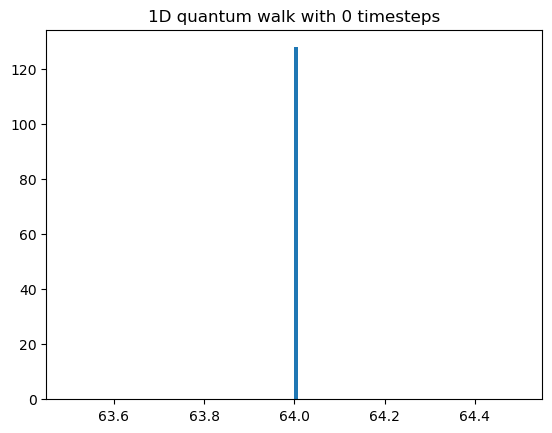

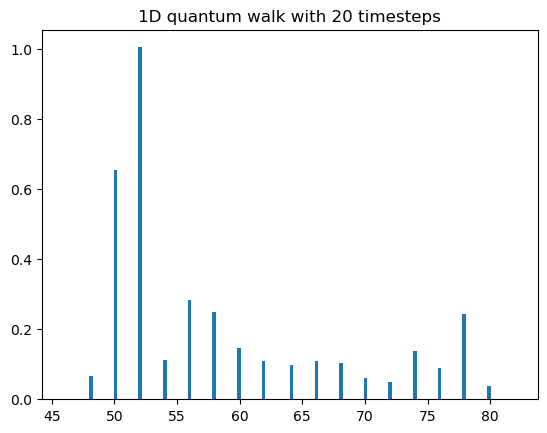

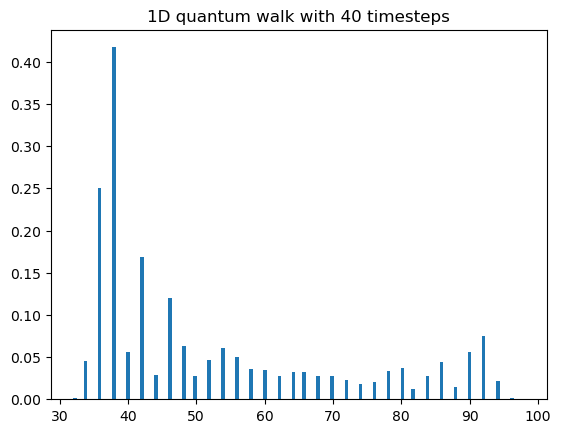

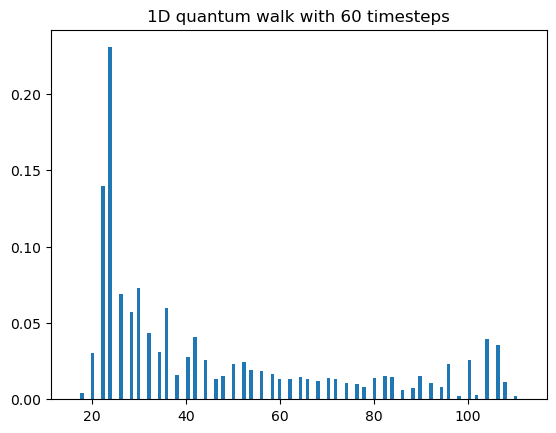

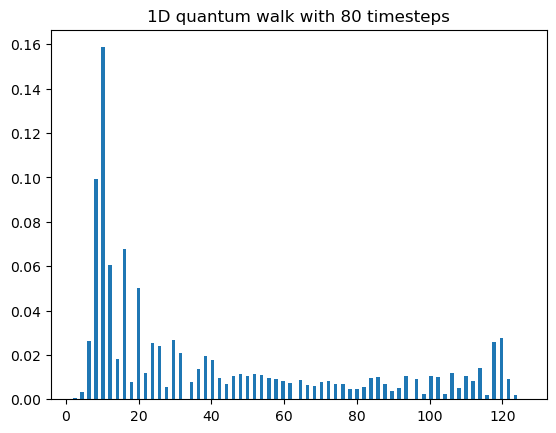

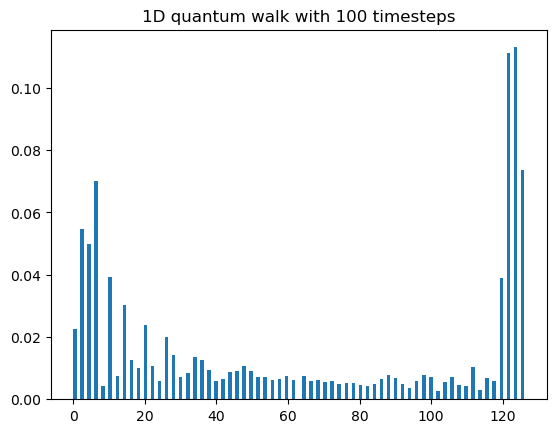

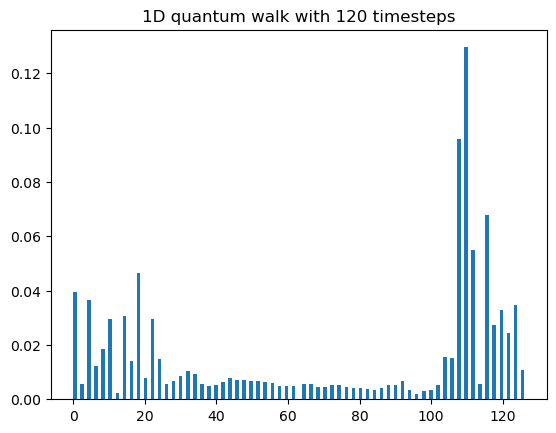

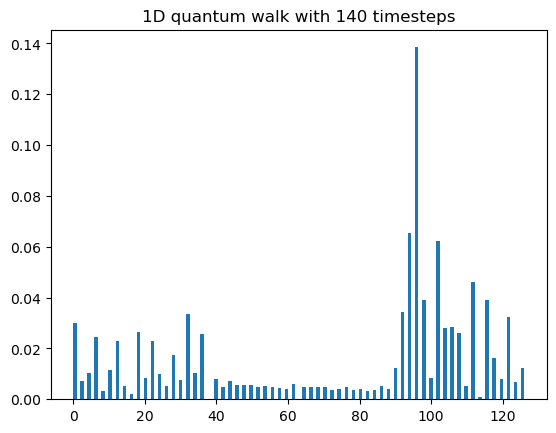

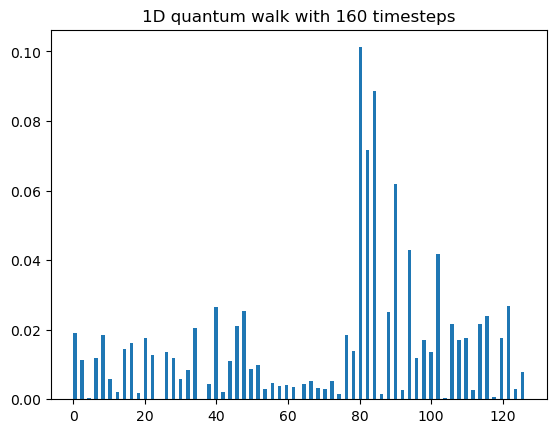

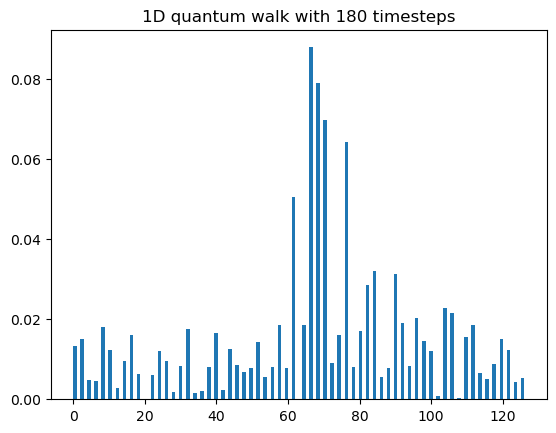

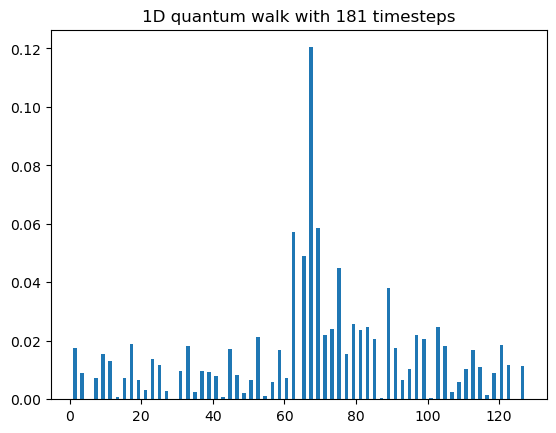

In [194]:
N_WIRES = 7
dev = pl.device("default.qubit", wires = ["coin", *range(N_WIRES)], shots = 10000)

# Multi-controlled X gate for CU_plus.
def mC0X_CU_plus(target):
    controls = list(np.arange(0, target, 1))
    controls.insert(0, "coin")
    control_zeros = np.zeros(target + 1, )
    control_zeros[0] = 1
    pl.MultiControlledX(wires=(*controls, target), control_values=control_zeros)
    return

# Controlled +1 transition unitary.
def CU_plus(n):
    for i in range(0, n):
        mC0X_CU_plus(i)
    return

# Multi-controlled X gate for CU_minus.
def mC0X_CU_minus(target):
    controls = list(np.arange(0, target, 1))
    controls.insert(0, "coin")
    control_zeros = np.zeros(target + 1, )
    pl.MultiControlledX(wires=(*controls, target), control_values=control_zeros)
    return


# Controlled -1 transition unitary.
def CU_minus(n):
    for i in range(1, n + 1):
        mC0X_CU_minus(n - i)
    return

# Quantum walk with T steps.
@pl.qnode(dev)
def quantum_walk(T):
    # find middle state and reverse bit string
    start = int(0.5 * (2 ** (N_WIRES)))
    start_state_rev = [int(d) for d in str(bin(start))[2:]]
    start_state = list(reversed(start_state_rev))
    states = list(enumerate(start_state))
    # input state
    for i, bit in states:
        if bit == 1:
            pl.PauliX(wires=i)
    # implement T steps
    for i in range(T):
        pl.Hadamard(wires="coin")
        CU_minus(N_WIRES)
        CU_plus(N_WIRES)
    return pl.sample()

print("Example circuit for two timesteps")
print(pl.draw(quantum_walk)(2))

# Plot the results below.
def plot_1d_timesteps(T):
    res = quantum_walk(T)

    # take all binary strings after coin bit
    res = [i[1:] for i in res]
    
    # reverse order of binary strings
    for i in range(len(res)):
        res[i] = res[i][::-1]
    
    # convert to ints
    walks = []
    for j in range(len(res)):
        res_int = int("".join(str(i) for i in res[j]), 2)
        walks.append(res_int)
    
    plt.title("1D quantum walk with %d timesteps"%T)
    plt.hist(walks, density=True, bins = 128)
    plt.show()

# plots to see how T varies
for i in range(200):
    if i % 20 == 0:
        plot_1d_timesteps(i)

# comparison of even and odd T
plot_1d_timesteps(181)



**What is different about classical and quantum case and why?**

The main difference is that the resulting distribution in the classical case is Gaussian whereas the quantum case returns and asymmetric distribution. This is likely due to the quantum superposition of states causing the quantum random walks to favour movement in one direction more than their classical counterparts. This in turn causes the quantum random walks to increase their expected distance from the starting position much faster than the classical random walks. This is supported by the fact that the particle is now most likely to be found furthest away from the starting position in the centre and closest to the boundaries. The quantum random walk distribution has a much lower weighting in the centre meaning that we are much less likely to find the particle closer to the starting position - the opposite to what was found for the classical random walk. Additionally, an element of randomness in inherent in the quantum case due to the superposition of states via the successive hadamard operations, whereas the same kind of randomness is not apparent in the classical case.

The reason for this difference is due to successive applications of the time-step operator which includes a Hadamard gate acting on the coin qubit. The coin begins in the $\ket{0}$ state and becomes $\ket{+}$ after the hadamard is applied. Let $\ket{\psi}$ be the state of the register. The $U^-$ operator then shifts the $\ket{0}\ket{\psi}$ component of the $\ket{+}\ket{\psi}$ down one position, and the opposite occurs for the $\ket{1}\ket{\psi}$ component being shifted up one position due to the $U^+$ operator. The second timestep then transforms the coin qubit back to $\ket{0}$, but now only a $U^-$ shift will be triggered as the control qubit is $\ket{0}$, meaning no $U^+$ shift. This process then repeats for $T/2$ timesteps. Clearly, this results in a net movement toward the lower positions as the $U^-$ is triggered for every timestep, whereas the $U^+$ is only triggered for odd timesteps. The particle is slowly moving toward the left (lower states) after each two successive timesteps. Therefore, the particle is most likely to be found at the lower positions which explains why we observe the peak around this area of the distribution. 

This can also be explained with respect to the cancellation of certain terms due to superposition and entanglement. The phase factor of $e^{i\pi} = -1$  will be introduced for states which have a tensor product with a $\ket{1}$ which has had the hadamard applied to it (i.e. the $\ket{+}\ket{\psi}$ state). This causes the states that have a tensor product with the $\ket{1}$ components of $\ket{-}\ket{\psi}$ to cancel out with the $\ket{1}$ components of $\ket{+}\ket{\psi}$, meaning paths that lead toward the higher positions destructively interfere, causing the asymmetric skew toward the left. Additionally, the $\ket{0}\ket{\psi}$ components are always positive and so will always constructively interfere, causing their probabilities to be amplified and so states that start with a tensor product to $\ket{0}$ of the coin qubit are positions where the particle is most likely to finish - hence the peak being shifted toward the lower states (which also have the highest number of $\ket{0}$s as a part of their binary representations).


**What if you vary T?**

The $T$ parameter is the number of steps the particle is permitted to be able to move within our "ring" of states. The size of our system is (excluding the coin qubit) $2^7 = 128$ positions. If $T = 64$ (half of system size) the distribution is shifted downward toward the lower states. If we double this and make $T$ equivalent to the size of our system, the distribution shifts even further and appears on the right due to the periodic boundary conditions that have been applied (i.e. the peak shifts so far left that it reappears on the right). In our ring model, this can be explained by the fact that the particle had twice as much freedom as before to move (i.e. it is able to take twice as many possible steps). This causes the $U^-$ operator to be applied more often than the $U^+$ operator, increasing the corresponding probability of the position to be shifted further downwards. The result is a net shift downwards (to the left) which causes the particle to reappear at the highest positions (on the right) due to the periodically repeating structure of the system. The peak also shifts at a constant rate which suggests that at time $T$ - the particle is most likely to be a distance of roughly $T$ away from the starting position. 

Additionally, as $T$ increases the distribution becomes more spread out, appearing to become more noisy across all states. This implies a link between the variance of the distribution and $T$, with a larger $T$ causing a larger variance. In the limit of a high number of timesteps the distribution then must spread out more, causing the peak to diminish in magnitude after shifting, with the probabilities of other positions increasing as a result of this spread. The spread diffuses ballistically with increasing $T$. This is another difference between the quantum and classical cases; the distribution spreads for a higher number of timesteps in the quantum random walk, but the classical random walk does not spread and the peak remains on the centre position. One can infer from this that as $T \rightarrow \infty$, the quantum random walk will approach a uniform distribution whereas the classical random walk will remain a Gaussian distribution.

One more observation is how the even/odd parity of $T$ affects the distribution. At an even timestep $T$ the particle only has non-zero probability of being found at an even position i.e. all odd positions have probability zero. The converse is true for odd timesteps. This means that particle is only ever moving from an odd to an even position from an odd to even timesteps and vice versa for even timesteps. This is consistent with the explanation above, as we are triggering both $U^+$ and $U^-$ on the odd timesteps and only $U^-$ on the even timesteps via the superposition of the coin qubit. We are then always going from an odd position to an even position at every even timestep and vice versa for odd timesteps. 


### Exercise 4 [10 marks]
Test what happens if the coin qubit is initialised to a different state than $\lvert 0 \rangle$. 

1. Write a function `init_coin(theta, phi)`, which rotates the coin qubit to an arbitrary state of the following form: *[3 marks]*

$$\lvert \psi_{coin} \rangle = \cos{(\theta)} \lvert 0 \rangle + {\rm e}^{i\phi} \sin{(\theta)} \lvert 1 \rangle$$

2. Rewrite `quantum_walk(T, theta, phi)`, with two new parameters that can be passed to `init_coin`. What do your results look like if you initialise the coin in state $\lvert \psi_{coin} \rangle = \lvert 1 \rangle$? What about $\lvert \psi_{coin} \rangle = \frac{1}{\sqrt{2}} (\lvert 0 \rangle + i \lvert 1 \rangle)$? Plot your results for both cases. How would you choose the number of time steps $T$? *[7 marks]*

Base case to check circuit - no rotation, one time step. Note the Phi gate returns the identity here.
coin: ──RX(0.00)──Rϕ(1.57)──H─╭○─╭○─╭○─╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●─╭●─╭●─╭●─┤  Sample
   0: ────────────────────────├○─├○─├○─├○─├○─├○─╰X─╰X─├○─├○─├○─├○─├○─├○─┤  Sample
   1: ────────────────────────├○─├○─├○─├○─├○─╰X───────╰X─├○─├○─├○─├○─├○─┤  Sample
   2: ────────────────────────├○─├○─├○─├○─╰X─────────────╰X─├○─├○─├○─├○─┤  Sample
   3: ────────────────────────├○─├○─├○─╰X───────────────────╰X─├○─├○─├○─┤  Sample
   4: ────────────────────────├○─├○─╰X─────────────────────────╰X─├○─├○─┤  Sample
   5: ────────────────────────├○─╰X───────────────────────────────╰X─├○─┤  Sample
   6: ──X─────────────────────╰X─────────────────────────────────────╰X─┤  Sample


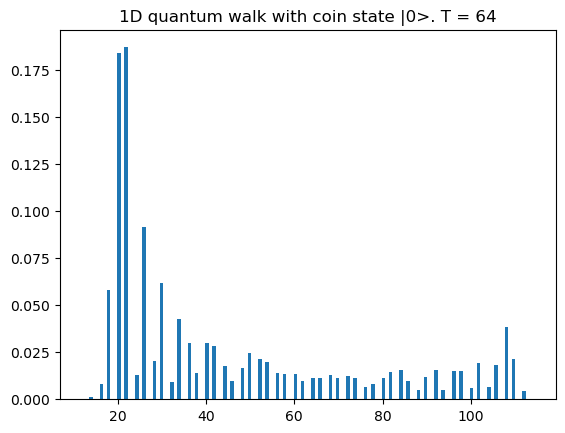

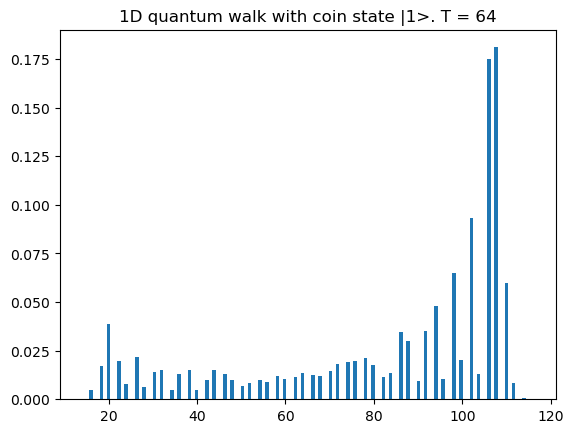

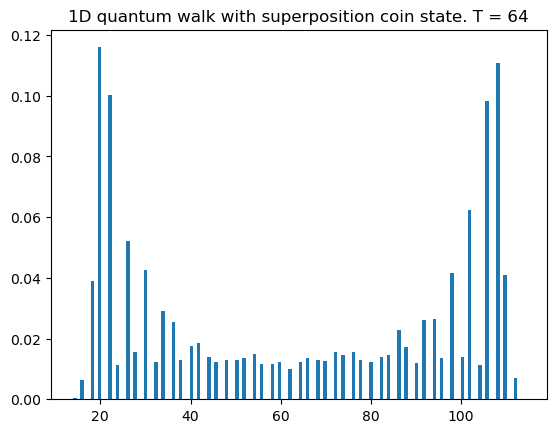

In [200]:
N_WIRES = 7
dev = pl.device("default.qubit", wires = ["coin", *range(N_WIRES)], shots = 10000)

# Init general coin register.
def init_coin(theta, phi):
    # returns cos(theta)|0> + e^(-i*pi/2)sin(theta)|1>
    pl.RX(2 * theta, wires="coin")
    # returns cos(theta)|0> + e^(i*phi)sin(theta)|1>
    pl.PhaseShift(phi + (np.pi/2), wires="coin")
    return

# Quantum walk with T steps, and given coin parameters.
@pl.qnode(dev)
def quantum_walk2d(T, theta, phi):
    init_coin(theta, phi)
    # find middle state and reverse bit string
    start = int(0.5 * (2 ** (N_WIRES)))
    start_state_rev = [int(d) for d in str(bin(start))[2:]]
    start_state = list(reversed(start_state_rev))
    states = list(enumerate(start_state))
    # input state
    for i, bit in states:
      if bit == 1:
        pl.PauliX(wires=i)
    # implement T steps
    for i in range(T):
      pl.Hadamard(wires="coin")
      CU_minus(N_WIRES)
      CU_plus(N_WIRES)
    return pl.sample()

print("Base case to check circuit - no rotation, one time step. Note the Phi gate returns the identity here.")
print(pl.draw(quantum_walk2d)(1, 0, 0))

def scenario(T, theta, phi):
    res = quantum_walk2d(T, theta, phi)
    
    # take all binary strings after coin bit
    res = [i[1:] for i in res]
    
    # reverse order of binary strings
    for i in range(len(res)):
        res[i] = res[i][::-1]
    
    # convert to ints
    walks = []
    for j in range(len(res)):
        res_int = int("".join(str(i) for i in res[j]), 2)
        walks.append(res_int)
    return walks
    
T = 64

# coin state |0>
s1 = scenario(T, 0, 0)
plt.title("1D quantum walk with coin state |0>. T = %d"%T)
plt.hist(s1, density=True, bins=128)
plt.show()

# coin state |1>
s2 = scenario(T, np.pi / 2, 0)
plt.title("1D quantum walk with coin state |1>. T = %d"%T)
plt.hist(s2, density=True, bins=128)
plt.show()

# coin state (|0> + i|1>)/sqrt(2)
s3 = scenario(T, np.pi / 4, np.pi / 2)
plt.title("1D quantum walk with superposition coin state. T = %d"%T)
plt.hist(s3, density=True, bins=128)
plt.show()

**Note on the init_coin function**

Below I highlight the method I used to obtain the rotated state in the exercise.

First use X rotation gate with input $2\theta$:

$$ R_{x}(2\theta) \lvert 0 \rangle = \cos{(\theta)} \lvert 0 \rangle - i \sin{(\theta)} \lvert 1 \rangle = \cos{(\theta)} \lvert 0 \rangle + {\rm e}^{-i\pi/2} \sin{(\theta)} \lvert 1 \rangle$$

Next apply phase shift gate:

$$ R_{\phi}(\phi + \pi/2) (\cos{(\theta)} \lvert 0 \rangle + {\rm e}^{-i\pi/2} \sin{(\theta)} \lvert 1 \rangle) = \cos{(\theta)} \lvert 0 \rangle + {\rm e}^{i\phi + \pi/2 - \pi/2 } \sin{(\theta)} \lvert 1 \rangle$$ 

Which simplifies to 

$$ \cos{(\theta)} \lvert 0 \rangle + {\rm e}^{i\phi} \sin{(\theta)} \lvert 1 \rangle$$

as required.

**What if initialize coin to state $\ket{1}$  ?**

The reason for this difference is due to the interference which occurs as a result of the additional phase factor introduced after the hadamard gates applied at odd intervals. The coin qubit begins in state $\ket{1}$ and the first timestep causes the state to transition to $\ket{-}$. The $U^-$ gate is then acts as it did before, shifting the $\ket{0}\ket{\psi}$ component of the $\ket{+}\ket{\psi}$ down one position. Then $U^+$ is applied to the $-\ket{1}\ket{\psi}$ component, shifting these states up one position. The next timestep then begins by causing the coin qubit to return back to $\ket{1}$. Now the timestep will not trigger $U^-$ as no $\ket{0}$'s are present and so only $U^+$ will be triggered, causing the position to shift up by one step for half of the states.  As discussed earlier, this is the same process but this time for the opposing direction - causing the peak to shift upward. This results in the particle being most likely to be found at the higher positions near the boundary when $T = 64$. 

This can again also be explained via interference due to the successive unitary timestep operations. Note that after the hadamard on the coin qubit, the $\ket{1}$ component of this state has an $e^{i\pi} = -1$ phase factor. Now if another hadamard is applied to this state, the resulting state becomes $\ket{-}$ which causes the $\ket{1}$ component to become positive and the $\ket{0}$ component to be negative. Clearly, the opposite of the first scenario occurs, where states that have a tensor product with the $\ket{1}$ components of the coin are now amplified but those that have a tensor product with $\ket{0}$ component of the coin cancel each other out. The resulting distribution then skews toward the right as position states that consist of a higher number of $\ket{1}$ within their binary representations have a higher probability of containing the particle after $T  = 64$ timesteps. 

**What about $(\ket{0} + i\ket{1})/\sqrt{2}$    ?**

Here we have a an equal likelihood of shifting the distribution toward the right and toward the left and so the result is a symmetric distribution where the particle becomes equally likely to be found at the lower positions and the higher positions (specifically around position 19 and position 120 from the above graph). Starting the coin in a superposition state with a phase factor of $e^{i\pi/2} = i$ on the $\ket{1}$ component of the coin causes successive hadamard operations on the coin qubit to prevent transformed $\ket{1}$  states to directly interfere with transformed $\ket{0}$. This is because $\ket{1}$ states now exist on the imaginary plane, seperated from $\ket{0}$ states which reside on the real plane.

As successive hadamard operations are now applied, the $\ket{0}$ and $\ket{1}$ states evolve independently. The states that develop via unitary operations that act on $i\ket{1}$ can no longer directly interfere with states from $\ket{0}$ and so we effectively have two subsystems evolving simultaneously under the same unitary operations. This is is a result we would expect intuitively if we initialized the coin state in both $\ket{0}$ and $\ket{1}$ (which we have indeed done via superposition). This is equivalent to superimposing both distributions (those with an imaginary coefficient and those without) atop one another and then normalising them to ensure we have a valid probability distribution which sums to 1. 


**How would you choose T?**

I initially thought that due to the link between $T$ and $\sigma^2$, some function $f(T) = f(\sigma^2, N)$ could be found which finds an optimal $\sigma^2$ via some optimization procedure and returns the corresponding $T$ value as a result. I am unsure on this though as there may be some non-linear relationship here and the resulting function may be too complex for this procedure to be implemented effectively. A possible solution could be to create an algorithm which minimizes the variance (starting at some $T = 2^{N - 2}$ or a quarter of the system size) step by step:

```
N = qubits
states = 2^N
T = 2^(N - 2)
for i in range(T, 2*states):
    prev_walk = quantum_random_walk(i-1)
    current_walk = quantum_random_walk(i)
    var_prev = var(prev_walk)
    var_current = var(current_walk)
    if var_current < var_prev:
        continue
    else:
        return i-1
```

The above ofcourse assumes convexity which may not be a valid assumption, however, if the above fails then the function $f(T) = f(\sigma^2, N)$ minimum could instead be found analytically. 

It may instead be more feasible to look for a relationship between $T$ and $\sigma$ which is more likely to be linear due to the fact that as $T$ increases, the distribution shifts in one direction at a constant rate, becoming more noisy with each shift. This suggests that the standard deviation of the spread may increase linearly with $T$ (given $T$ is discrete), as the distribution does not average out and instead continues to shift. In a classical random walk, the standard deviation follows that of a gaussian distribution which means $\sigma_{\text{classical}} = \sqrt{T}$. Given that the quantum random walk maintains a ballistic spread but over two potential directions, we can assume that $\sigma_{\text{quantum}} = T$.

Another possible value for $T$ is half of the size of the system we use. A system of N qubits would then require $T = 2^{N - 1}$ timesteps to produce a clear distribution. This is due to the results from exercise 3 which showed that a $T$ below this number producing a sparse distribution which does not allow for the quantum effects to emerge, and a $T$ above this number having the propensity too shift too far and become too noisy. Also - it is worth noting that depending on the size of the system and the computational resources at hand, a larger $T$ may become to expensive to compute, especially for larger systems if this particular selection method is used. 



### Exercise 5 [10 marks]

How would you implement the classical walk on a quantum computer? Apply any ideas from the Pennylane library. Try to reproduce the results from part 1, but feel free to tweak any device parameters if it takes too long to run. 

1. Write `classical_walk(T)` below to simulate the classical walk with boundary conditions for $T$ time steps, similar to the second example in part 1. Plot your results. *[10 marks]*

Example circuit for two timesteps
coin: ──H──┤↗├─╭○─╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●─╭●──H──┤↗├─╭○─╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●─╭●─┤  Sample
   0: ─────────├○─├○─├○─├○─╰X─╰X─├○─├○─├○─├○─────────├○─├○─├○─├○─╰X─╰X─├○─├○─├○─├○─┤  Sample
   1: ─────────├○─├○─├○─╰X───────╰X─├○─├○─├○─────────├○─├○─├○─╰X───────╰X─├○─├○─├○─┤  Sample
   2: ─────────├○─├○─╰X─────────────╰X─├○─├○─────────├○─├○─╰X─────────────╰X─├○─├○─┤  Sample
   3: ─────────├○─╰X───────────────────╰X─├○─────────├○─╰X───────────────────╰X─├○─┤  Sample
   4: ──X──────╰X─────────────────────────╰X─────────╰X─────────────────────────╰X─┤  Sample


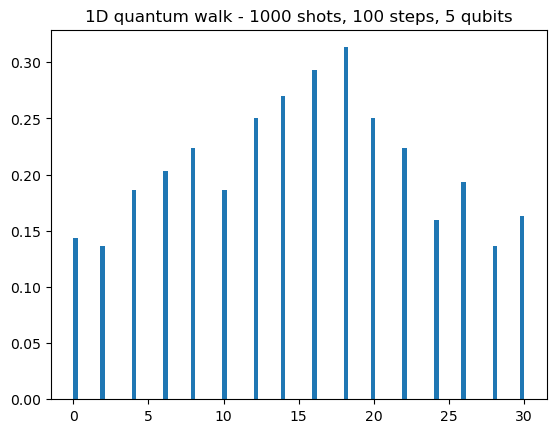

In [204]:
N_STEPS = 100
N_WIRES = 5
dev = pl.device("default.qubit", wires = ["coin", *range(N_WIRES)], shots = 1000)

@pl.qnode(dev)
def classical_walk(T):
  start = int(0.5 * (2 ** (N_WIRES)))
  start_state_rev = [int(d) for d in str(bin(start))[2:]]
  start_state = list(reversed(start_state_rev))
  states = list(enumerate(start_state))
  for i, bit in states:
    if bit == 1:
      pl.PauliX(wires=i)
  # implement T steps
  for i in range(T):
    pl.Hadamard(wires="coin")
    pl.measure(wires="coin")
    CU_minus(N_WIRES)
    CU_plus(N_WIRES)
  return pl.sample()

print("Example circuit for two timesteps")
print(pl.draw(classical_walk)(2))

# Plot the results below.
# Plot the results below.
res = classical_walk(N_STEPS)

# take all binary strings after coin bit
res = [i[1:] for i in res]

# reverse order of binary strings
for i in range(len(res)):
    res[i] = res[i][::-1]

# convert to ints
walks = []
for j in range(len(res)):
    res_int = int("".join(str(i) for i in res[j]), 2)
    walks.append(res_int)

plt.title("1D quantum walk - %d shots, %d steps, %d qubits"%(1000, N_STEPS, N_WIRES))
plt.hist(walks, density=True, bins = N_STEPS)
plt.show()

**Classical walk on quantum computer**

We should keep the $U^{+}$ and $U^{-}$ transitions as they allow for the movement of the particle i.e. 

$$U^{+}\ket{k} = \ket{k+1} \text{  iff coin} = \ket{1}$$
$$U^{-}\ket{k} = \ket{k-1} \text{  iff coin} = \ket{0}$$

So we must focus on the coin qubit. The initial hadamard on the coin should not change as this gives a 50:50 chance for the coin being in state $\ket{0}$ or $\ket{1}$ which is needed for the classical case. If we measure this qubit it would cause the coin to collapse into either the $\ket{0}$ or $\ket{1}$ state with a 50:50 probability - so we must incorporate measurements during each step to allow for the probability of a step in either direction (i.e. implementing $U^{+}$ or $U^{-}$) 50:50 as desired. Using the same unitary evolution for one timestep as seen in the previous question, we conduct a measurement before the $U^{-}$ and $U^{+}$ gates and after the Hadamard. Repeating this for each timestep should theoretically give the same conditions as the classical case.

This is because each step is initialized with a Hadamard which causes a superposition of either $H\ket{0} = \ket{+}$ or $H\ket{1} = \ket{-}$. Once measured we either collapse back to $\ket{0}$ with 50% probability or $\ket{1}$  with 50% probability in either the $\ket{+}$  or $\ket{-}$  states. The position state becomes a Bernoulli random variable with the implementation of the above, simulating the classical walk seen previously. The code above replicates the plot seen in exercise 1 as best as possible, however, the total walk is much more computationally expensive and so takes a longer time to run. 

The histogram for exercise 1 cannot be recreated exactly due to the size of the statespace for N qubits being $2^N$. The closest approximation to the histogram seen for random_walk_bc can be acheived by passing the paramaters N_STEPS = 100, N_WIRES = 5, shots=100000. To simulate a classical systems size of 40 spaces we use $2^5 = 32$ qubits. Results show that the distribution for the quantum random walk is sharper than that for the classical random walk. The pobability amplitude for the largest peak for the quantum random walk is roughly 0.30 (compared to the flatter classical random walk which peaks at 0.08) however, this is likely due to the different system sizes. 

Please note that I reduced the shots to 1000 in the above code in order to compute in a reasonable time and the result was a noisy Gaussian due to the lower number of shots. I tested the same code on my computer in the larger limit of shots and repoduced a perfect Gaussian distribution as expected and have embedded the image here:


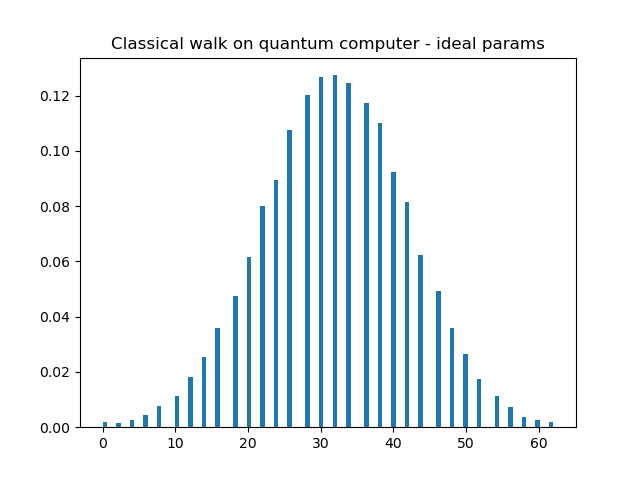



## Part 3 – 2D Quantum Walk

Now you can use all of the ideas from previous part to construct a similar circuit that conducts the quantum walk in 2-dimensions. 


![image](2d-grid.svg)

You can assume that the grid is of dimensions $2^N \times 2^M$, so the first $M$ qubits represent columns, while the next $N$ represent rows. Use named registers to help you identify which qubits you are acting on. Instead of -1 and +1 transitions, now you will need left, right, up and down transitions. To control them, use two coin qubits, one for vertical directions, and one for horizontal. 

### Exercise 6 [25 marks]

Use the ideas from previous exercises to implement a 2D quantum walk below. Make it flexible for different numbers of column and row qubits. This time, return the expectation value instead of samples. Feel free to define any helper methods. 

1. Implement gates for transitions in each Cartesian direction. Make horizontal transitions controlled on one qubit, and horizontal transitions controlled on the other qubit. Make use of named wires. *[12 marks]*
2. Implement the 2D quantum walk. Make it return the expectation value instead of a sample. For now, leave the initial coin state as $\lvert 00 \rangle$. *[4 marks]*
3. Test your code and plot the results (e.g. as 2D histograms) for different $T$ on a 16x32 grid. How do they compare to the 1D case? How would you expect them to change for different initial states? *[9 marks]*

Circuit example for 00 start state coin register with 2 timesteps
coin1: ──H─╭○─╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●─╭●──H─────────────────────────╭○─╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●─╭●───
coin2: ──H─│──│──│──│──│──│──│──│──│──│──╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●──H─│──│──│──│──│──│──│──│──│──│──╭○
 col0: ────├○─├○─├○─├○─╰X─╰X─├○─├○─├○─├○─│──│──│──│──│──│──│──│─────├○─├○─├○─├○─╰X─╰X─├○─├○─├○─├○─│─
 col1: ────├○─├○─├○─╰X───────╰X─├○─├○─├○─│──│──│──│──│──│──│──│─────├○─├○─├○─╰X───────╰X─├○─├○─├○─│─
 col2: ────├○─├○─╰X─────────────╰X─├○─├○─│──│──│──│──│──│──│──│─────├○─├○─╰X─────────────╰X─├○─├○─│─
 col3: ────├○─╰X───────────────────╰X─├○─│──│──│──│──│──│──│──│─────├○─╰X───────────────────╰X─├○─│─
 col4: ──X─╰X─────────────────────────╰X─│──│──│──│──│──│──│──│─────╰X─────────────────────────╰X─│─
 row0: ──────────────────────────────────├○─├○─├○─╰X─╰X─├○─├○─├○──────────────────────────────────├○
 row1: ──────────────────────────────────├○─├○─╰X───────╰X─├○─├○──────────────────────────────────├○
 row2: ──────────────────

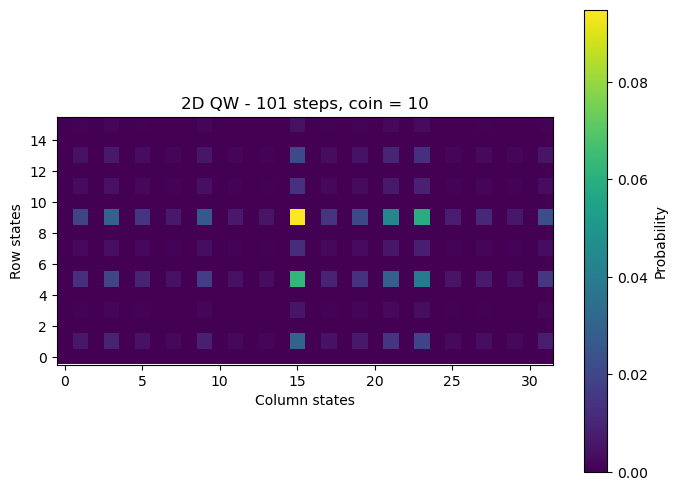

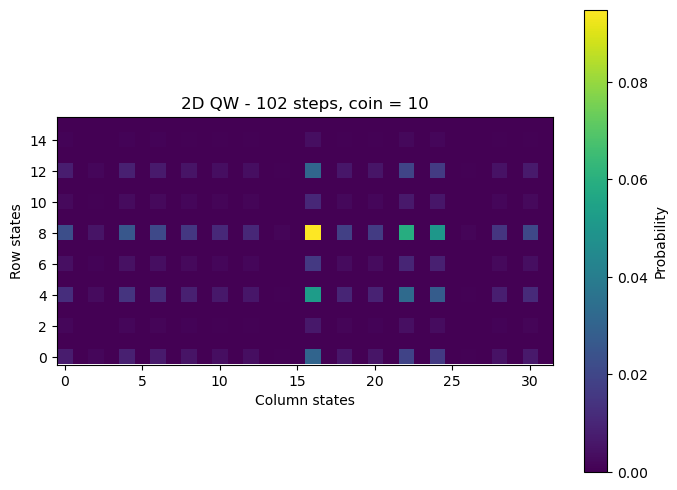

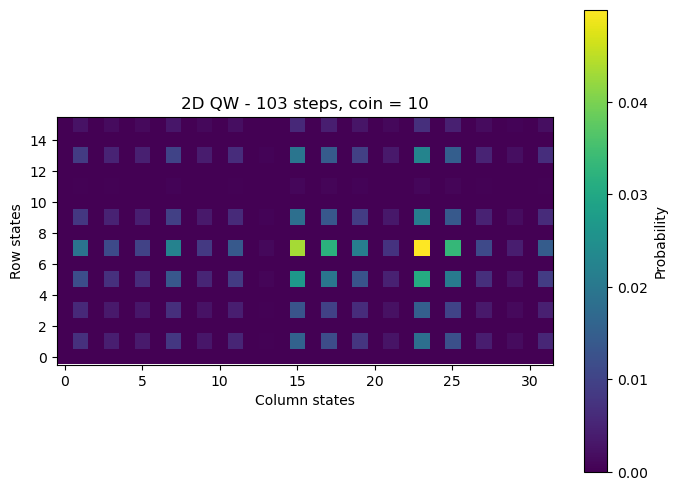

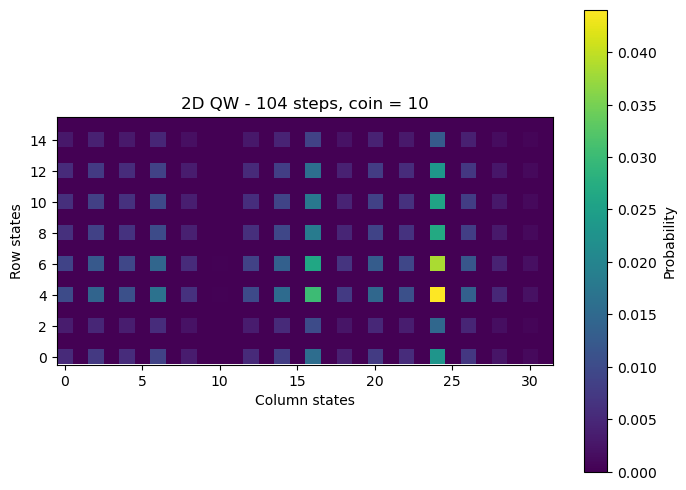

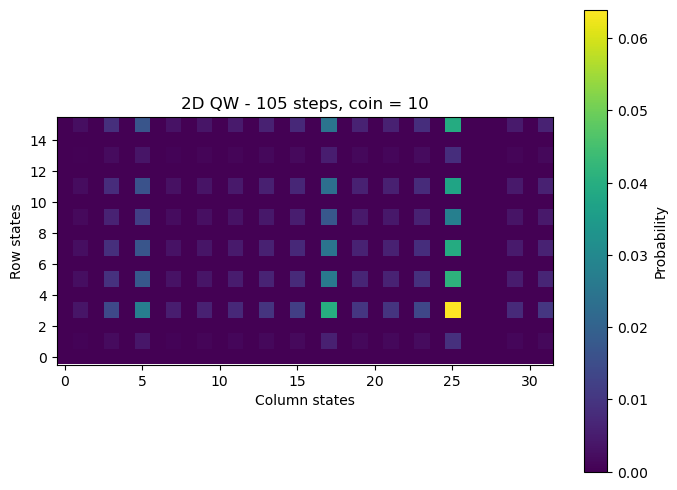

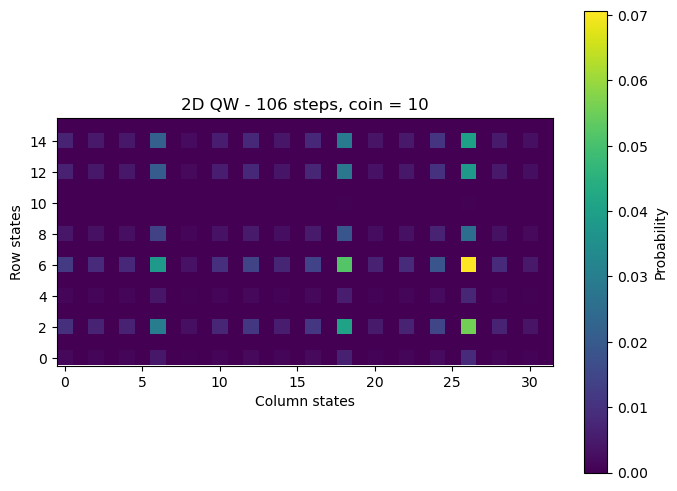

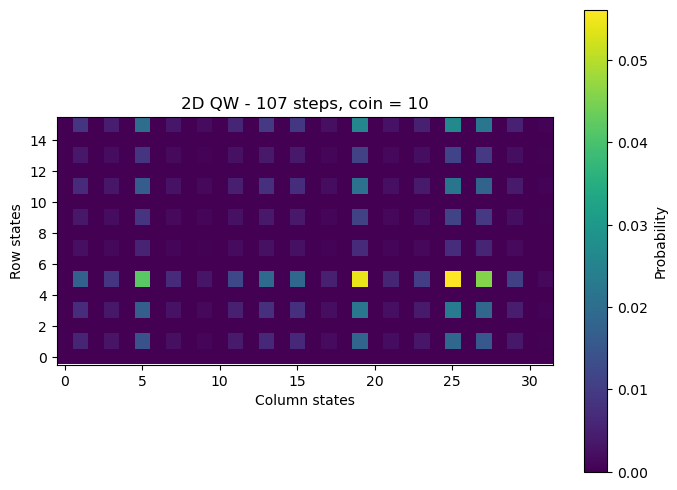

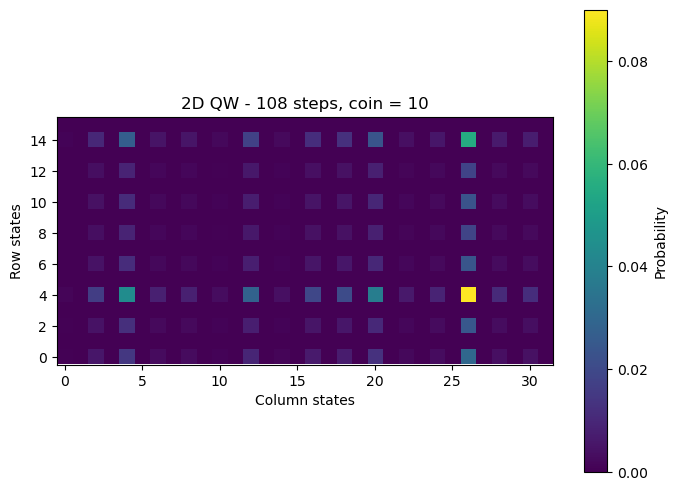

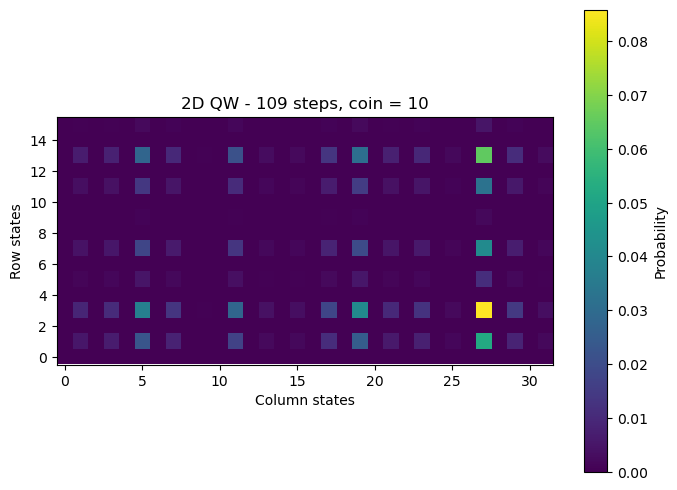

'\n# odd and even timesteps \nfor i in range(1, 5):\n    plot2d(1000 + i, 0, 0)\n\n\n# changing coin states - even parity\nT = 100\n\n# start state 00\nplot2d(T, 0, 0)\n\n# start state 01\nplot2d(T, 0 ,1)\n\n# start state 10\nplot2d(T, 1 ,0)\n\n# start state 11\nplot2d(T, 1 ,1)\n\n\n# changing coin states - odd parity\nT = 101\n\n# start state 00\nplot2d(T, 0, 0)\n\n# start state 01\nplot2d(T, 0 ,1)\n\n# start state 10\nplot2d(T, 1 ,0)\n\n# start state 11\nplot2d(T, 1 ,1)\n'

In [11]:
N = 4
M = 5

COIN_REG = ["coin1", "coin2"]
ROW_REG = ["row%d"%i for i in range(N)]
COL_REG = ["col%d"%i for i in range(M)]

dev = pl.device("default.qubit", wires = COIN_REG + COL_REG + ROW_REG)

# function for positive step in x (positive col)
def CCU_right():
  controls = [COIN_REG[1]]
  for i in ROW_REG:
    control_zeros = np.zeros(len(controls), )
    control_zeros[0] = 1
    pl.MultiControlledX(wires=(*controls, i), control_values=control_zeros)
    controls = np.append(controls, i)
  return


# function for negative step in x (negative col)
def CCU_left():
  controls = [COIN_REG[1]] + ROW_REG[0:-1]
  for i in enumerate(ROW_REG):
    t = ROW_REG[-1-i[0]]
    control_zeros = np.zeros(len(controls), )
    pl.MultiControlledX(wires=(*controls, t), control_values=control_zeros)
    controls = controls[:-1]
  return


# function for positive step in y (positive row)
def CCU_up():
  controls = [COIN_REG[0]]
  for i in COL_REG:
    control_zeros = np.zeros(len(controls), )
    control_zeros[0] = 1
    pl.MultiControlledX(wires=(*controls, i), control_values=control_zeros)
    controls = np.append(controls, i)
  return


# function for negative step in y (negative row)
def CCU_down():
  controls = [COIN_REG[0]] + COL_REG[0:-1]
  for i in enumerate(COL_REG):
    t = COL_REG[-1 - i[0]]
    control_zeros = np.zeros(len(controls), )
    pl.MultiControlledX(wires=(*controls, t), control_values=control_zeros)
    controls = controls[:-1]
  return

# initialize state of each register
def initialise_register(register):
  start = int(0.5 * (2 ** (len(register))))
  start_state_rev = [int(d) for d in str(bin(start))[2:]]
  start_state = list(reversed(start_state_rev))
  state = list(enumerate(start_state))
  for i, bit in state:
    if bit == 1:
      pl.PauliX(wires=register[i])

@pl.qnode(dev)
def quantum_walk_2d(T, c1, c2):
    initialise_register(COL_REG)
    initialise_register(ROW_REG)
    if c1 == 1:
        pl.PauliX(wires=COIN_REG[0])
    if c2 == 1:
        pl.PauliX(wires=COIN_REG[1])
    for i in range(T):
        pl.Hadamard(wires=COIN_REG[0])
        pl.Hadamard(wires=COIN_REG[1])
        CCU_down()
        CCU_up()
        CCU_left()
        CCU_right()
    return pl.state()

print("Circuit example for 00 start state coin register with 2 timesteps")
print(pl.draw(quantum_walk_2d)(2, 0, 0))

# define function to find the reverse bit string states as ints from a register depending on size of register
def find_states(register):
  no_qubits = 2 ** len(register)
  int_states = [i for i in range(no_qubits)]
  bin_states = [[int(d) for d in str(bin(i))[2:]] for i in int_states]
  for item in bin_states:
    decide = len(bin_states[-1]) - len(item)
    for j in range(decide):
      item.insert(0, 0)
  rev_bin_states = [list(reversed(i)) for i in bin_states]
  rev_int_states = []
  for j in range(len(rev_bin_states)):
    res_int = int("".join(str(i) for i in rev_bin_states[j]), 2)
    rev_int_states.append(res_int)
  return rev_int_states


# function to find probability map and plot
def plot2d(T, c1, c2):
    states = quantum_walk_2d(T, c1, c2)
    prob = np.abs(states) ** 2

    # factorise out coin qubits
    prob2 = np.split(prob, 2 ** 2)
    
    # sum of factorised prob states
    probabilities = [sum(row[i] for row in prob2) for i in range(len(prob2[0]))]

    # create grid
    probability_grid = np.reshape(probabilities, (2 ** N, 2 ** M))
    
    # reverse bit string to int list for each register
    row_states = find_states(ROW_REG)
    col_states = find_states(COL_REG)

    # reorder probability grid according to above
    for i in range(len(col_states)):
        for j in range(len(row_states)):
            x_idx = row_states[j]
            y_idx = col_states[i]
            probability_grid[x_idx, y_idx] = probabilities[i * len(row_states) + j]

    plt.figure(figsize=(8, 6))
    plt.imshow(probability_grid, origin='lower')
    plt.colorbar(label="Probability")
    plt.ylabel('Row states')
    plt.xlabel('Column states')
    plt.title("2D QW - %d steps, coin = %d%d" % (T, c1, c2))
    plt.show()

# I have commented out the below as I looked through a lot of different graphs to spot patterns.

# to check how the statespace evolves per timestep
for i in range(1, 10):
    plot2d(100+i, 1, 0)

"""
# odd and even timesteps 
for i in range(1, 5):
    plot2d(1000 + i, 0, 0)


# changing coin states - even parity
T = 100

# start state 00
plot2d(T, 0, 0)

# start state 01
plot2d(T, 0 ,1)

# start state 10
plot2d(T, 1 ,0)

# start state 11
plot2d(T, 1 ,1)


# changing coin states - odd parity
T = 101

# start state 00
plot2d(T, 0, 0)

# start state 01
plot2d(T, 0 ,1)

# start state 10
plot2d(T, 1 ,0)

# start state 11
plot2d(T, 1 ,1)
"""

**Method Explained**

The 2D random walk is essentially two 1D random walks that evolve alongside one another via seperate timestep operators. Coin 1 was used for the register of $M$ qubits which give rise to the column position states along the $x$ axis. Coin 2 was then used for the $N$ qubits which represent the row position states along the $y$ axis. A timestep operator was applied from these coins to their respective registers, with one timestep in the 2d case being one application of the timestep on the row positions and one application on the column positions. A movement in the question was not exclusively defined to be along either one of the row or column states and so I have assumed a single movement in the 2D case involves a 1D movement along the row states followed by a 1D movement along the column states. CCU_right and CCU_left are then transitions along the column states whereas CCU_up and CCU_down are row state transitions. 

Once the statevector of the system was returned, the probabilities of each state were found using abs and squaring. Given that the first two qubits are coin states, these must be discarded so that only the register states remain. To acheive this we split the array into $2^2 = 4$ sections in order to factorise out the coin qubit states and then we sum the resulting sub arrays which are in lexographical order for the tensor product of the column and row states. The array is then reshaped by $2^N$ x $2^M$. The respective bitstring states for each integer state are reversed and the probability array is reordered according to this and plotted.

**Comparison to 1D case**

As explained earlier - the 2D histogram above displays what would be expected of superimposing two 1D histograms atop one another. The resulting joint distribution reflects the probability of finding the particle depending on its row position and its column position. These distributions are independent from one another as they evolve using seperate coin qubits. We can then write, for the probability of finding a particle at some x, y position within a discrete time $T$:

$$ \sum_{x, y} p(x,y) = \sum_{x, y}p(x)p(y) $$

Above, $p(x)$ corresponds finding the particle at position $x$ along the column states and $p(y)$ corresponds finding the particle at position $y$ along the row states. The resulting distribution is expressed as a two-dimensional probability plane. The resulting 2D histrogram supports this, showing a clear peak where the probability of the register states overlap and smaller peaks for the other states which have overlapped but have a lower probability. This is analagous to the 1D state where the probability distribution was spread over the entire state-space.

As one would expect from the 1D quantum case due to the coin qubits starting in $\ket{00}$, successive timesteps push the distribution further toward the lower positional states for both the row and column qubits. Note that the 2D quantum walk walk also shows that after an even number of timesteps the particle can only be found at the intersection of even states between the row and column positions. The converse is true for odd timesteps meaning that this is consistent with what one would expect from a 1D random walk. As both row and column qubits experience this for each timestep simultaneously, the result is a shift in the position of the distribution for every successive timestep, analagous to what was seen in the 1D case. Due to periodic boundary conditions, we notice that after a certain number of timesteps the distribution is shifted so far toward the lower states it reappears at the higher states which is in agreement with observations for the 1D case.

This can again be attributed to $U^+$ and $U^-$ being applied on the odd timesteps and only $U^-$ on the even timesteps, effectively shifting the distribution ballistically in one direction (toward the lower states in this case due to the coin qubit being $\ket{00}$). This is only possible because the row and column states are connected via a tensor product within the circuit meaning that constructive and destructive interference occurs for the entire state comprising of both registers (excluding the coin register). This repeats for each timestep which, due to boundary conditions, continues to move the peak diagonally (left-downward) toward the lower states. Note that the shift is larger in the 2D case compared to the 1D case because we see that the distribution reappears on with the peak around the higher states for a lower number of timesteps. This is likely due to the fact that we now have a standard deviation of T in for two 1D quantum walks covering 4 degrees of freedom, meaning $\sigma_{\text{quantum}}^{2\text{D}} = T^2$. The increase standard deviation of the joint distribution explains how the ballistic shift of the distribution is larger than its 1D counterpart. It should be noted that each timestep operator continues to have an effect on the superposition between the qubits of each register which drives the respective cancellations of higher positional states and amplifications of lower positional states as was seen in 1D. For 2D this effect occurs in two different directions which gives rise to the distribution observed. Additionally, the hadamard transformations do not cause the states from each register to entangle with one another. This is supported by the fact that the distribution presents symmetry between the x and y directions.


**Changing coin states**

Changing the coin state affects the direction of the ballistic shift of the distribution - analagous to what was seen in 1D. 

For $\ket{00}$ the coin state, the distribution is skewed to have an asymmetry toward the lower states and so each timestep shifts the distribution toward the lowest positional states for both row and column registers (diagonally down toward the left). If we initialize the coin state to $\ket{11}$, the opposite effect occurs and we now shift the distribution toward the higher positional states (diagonally up toward the right). This is reflected by the fact that, on even timesteps, the peak is being pushed outward toward the higher states for both column and row qubit registers. 

For coin $\ket{01}$ we notice that the distribution now shifts toward the lower column states but higher row states (diagonally up toward the left). This is because the first coin qubit is the control bit for the column states, whereas the second coin bit is the control for the row states. In this scenario, each timestep is simultaneously maximising the row state but minimising the column state. The opposite of this is true for the coin state starting in $\ket{10}$, where here each timestep is instead maximising the column state but minimising the row state (diagonally down toward the right). Due to the hadamard introducing the phase shift of $-1$ on $\ket{1}$ one timestep before $\ket{0}$, we essentially get a superposition of states which are out of phase with one another and so can only constructively or destructively interfere at every even timestep for even integer position states and at odd timesteps for odd integer position states. 



The double Hadamard gate applied to the coin register before each walk step is called the **Hadamard coin**. This is not the only coin valid for the quantum walk. Let's consider the following two additional coins:
* The **Fourier coin**: 

$$
\hat{F}_4 = \frac{1}{2} \begin{pmatrix}
1 &  1 &  1 &  1 \\
1 &  i & -1 & -i \\
1 & -1 &  1 & -1 \\
1 & -i & -1 &  i
\end{pmatrix}
$$

* The **Grover coin**: 

$$
\hat{G}_4 = \frac{1}{2} \begin{pmatrix}
-1 &  1 &  1 &  1 \\
 1 & -1 &  1 &  1 \\
 1 &  1 & -1 &  1 \\
 1 &  1 &  1 & -1
\end{pmatrix}
$$


### Exercise 7 [15 marks]

Modify your code for the 2D quantum walk to allow arbitrary initial state and coin gate. Plot the results for the following configurations: 
1. Hadamard coin and $\frac{1}{2} (\lvert 0 \rangle + i \lvert 1 \rangle) \otimes (\lvert 0 \rangle + i \lvert 1 \rangle)$ initial state. *[4 marks]*
2. Fourier coin and $\frac{1}{2} (\lvert 00 \rangle + e^{-\pi/4} \lvert 01 \rangle + \lvert 10 \rangle - e^{-\pi/4} \lvert 11 \rangle)$ initial state. *[4 marks]*
3. Grover coin and $\lvert - \rangle \otimes \lvert - \rangle$ initial state. *[4 marks]*
4. Describe how the results differ from each other. Suggest why this is the case. *[3 marks]*

Hadamard coin circuit
coin1: ──RX(1.57)──Rϕ(3.14)──H─╭○─╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●─╭●──H─────────────────────────╭○─╭○─╭○─╭○
coin2: ──RX(1.57)──Rϕ(3.14)──H─│──│──│──│──│──│──│──│──│──│──╭○─╭○─╭○─╭○─╭●─╭●─╭●─╭●──H─│──│──│──│─
 col0: ────────────────────────├○─├○─├○─├○─╰X─╰X─├○─├○─├○─├○─│──│──│──│──│──│──│──│─────├○─├○─├○─├○
 col1: ────────────────────────├○─├○─├○─╰X───────╰X─├○─├○─├○─│──│──│──│──│──│──│──│─────├○─├○─├○─╰X
 col2: ────────────────────────├○─├○─╰X─────────────╰X─├○─├○─│──│──│──│──│──│──│──│─────├○─├○─╰X───
 col3: ────────────────────────├○─╰X───────────────────╰X─├○─│──│──│──│──│──│──│──│─────├○─╰X──────
 col4: ──X─────────────────────╰X─────────────────────────╰X─│──│──│──│──│──│──│──│─────╰X─────────
 row0: ──────────────────────────────────────────────────────├○─├○─├○─╰X─╰X─├○─├○─├○───────────────
 row1: ──────────────────────────────────────────────────────├○─├○─╰X───────╰X─├○─├○───────────────
 row2: ──────────────────────────────────────────────────────├○─╰X────────────

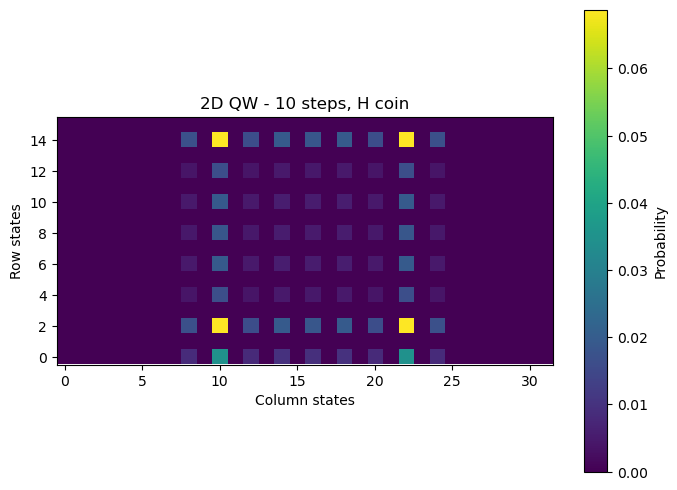

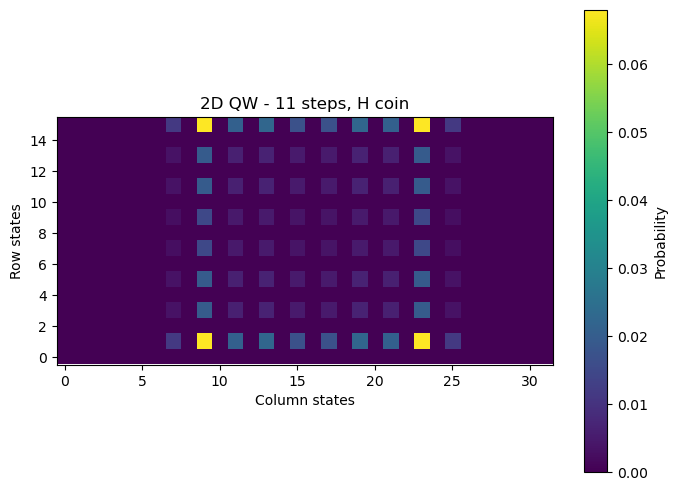

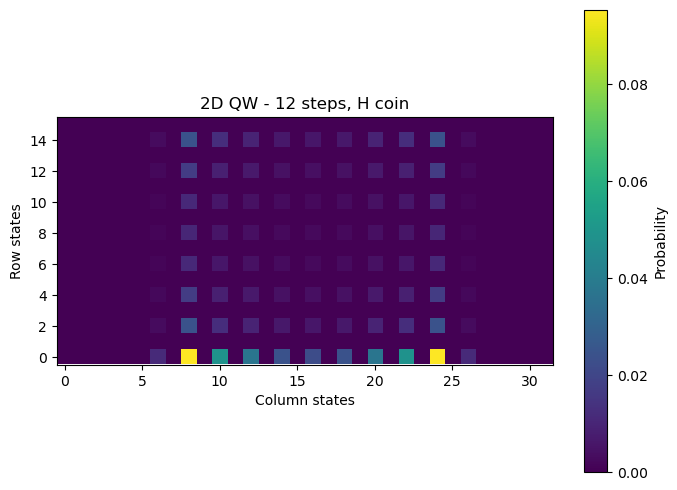

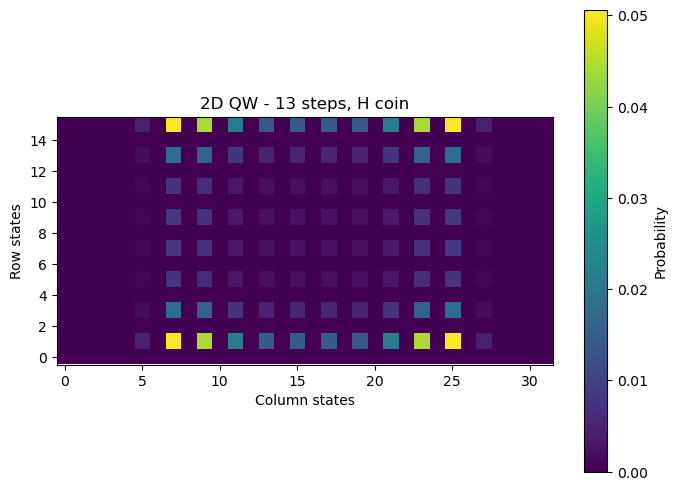

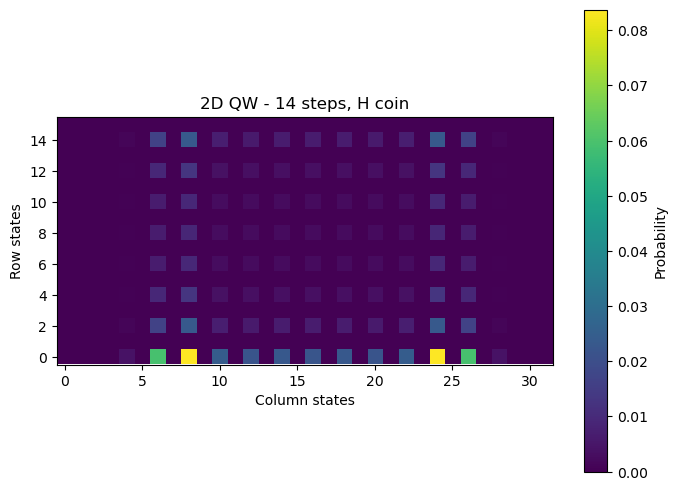

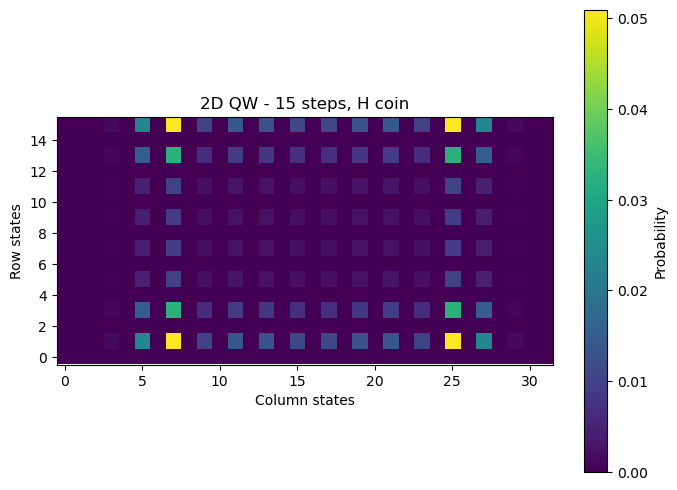

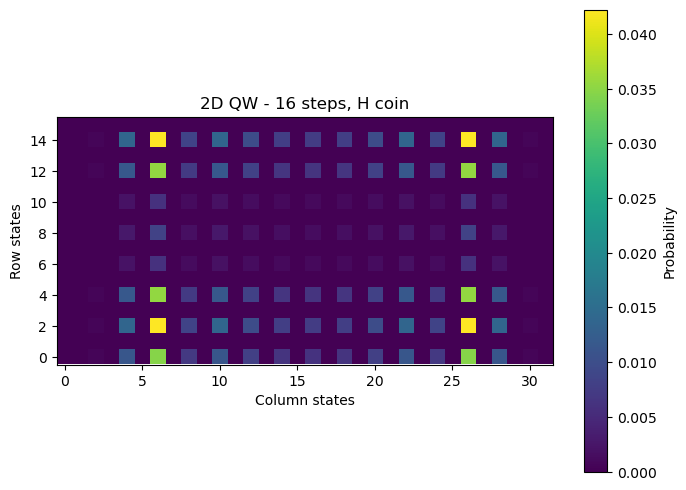

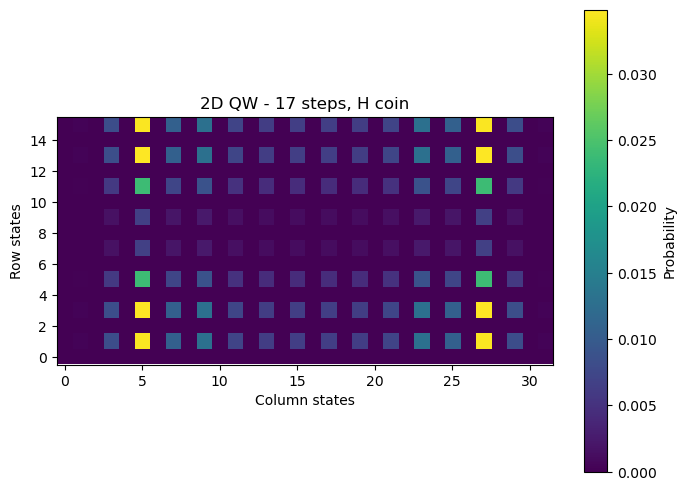

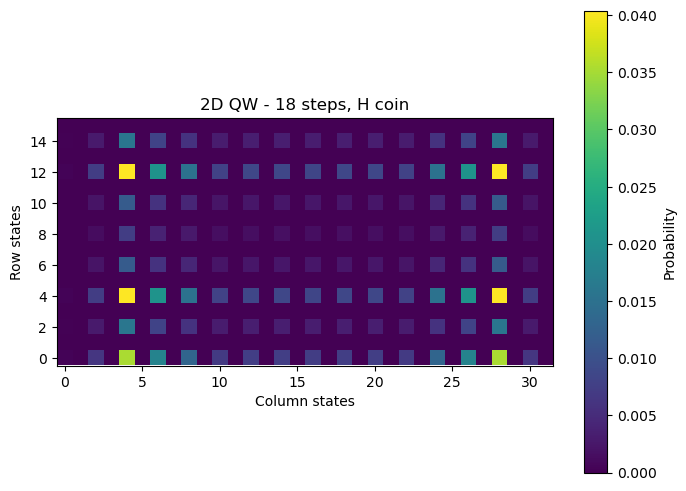

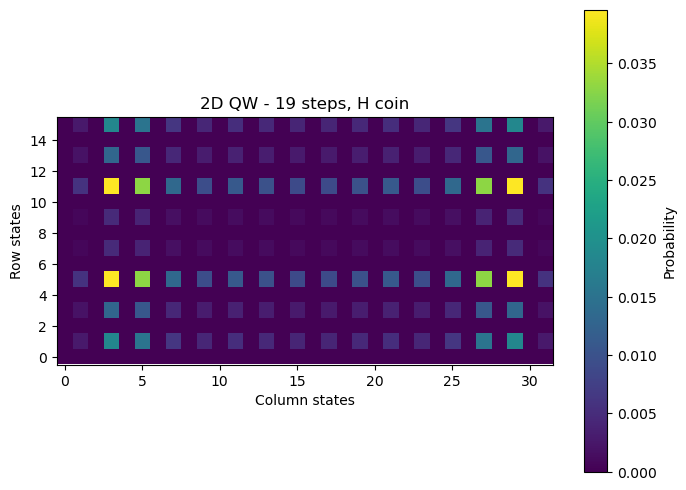

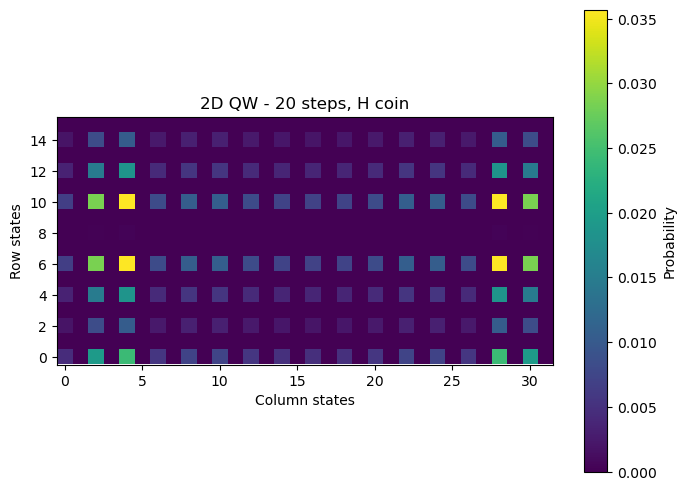

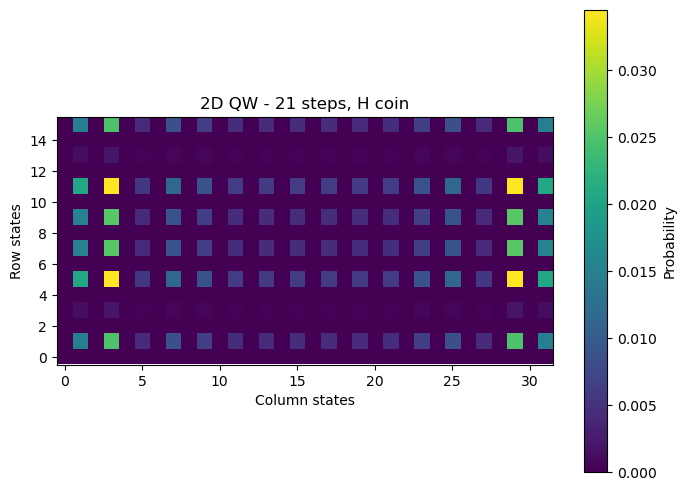

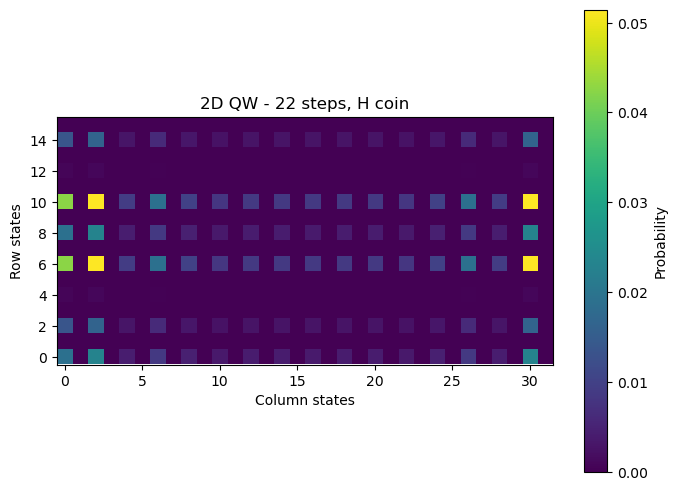

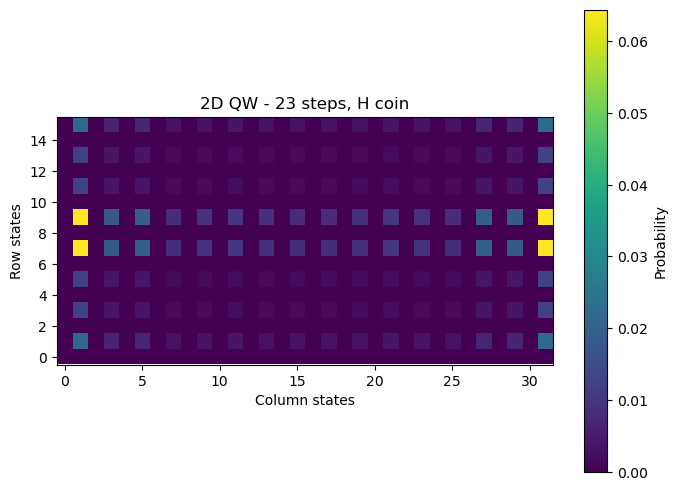

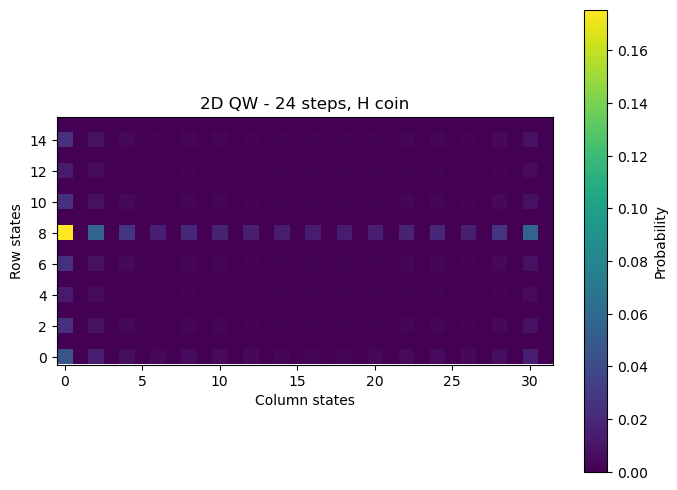

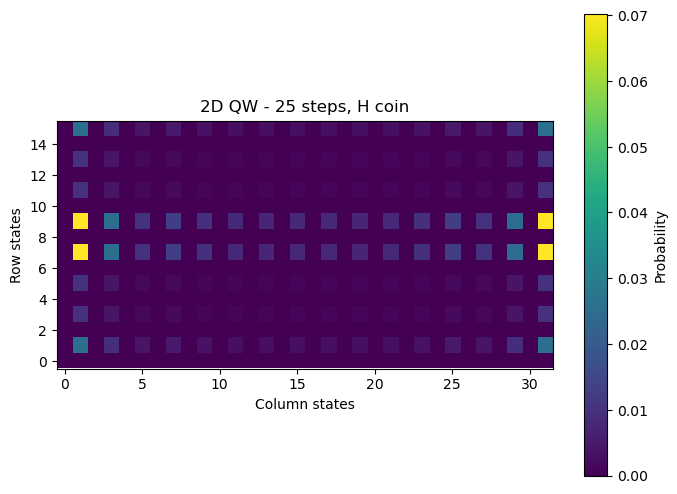

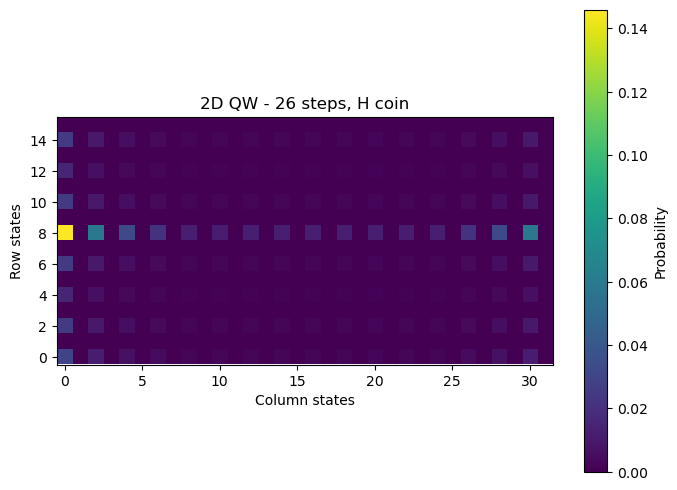

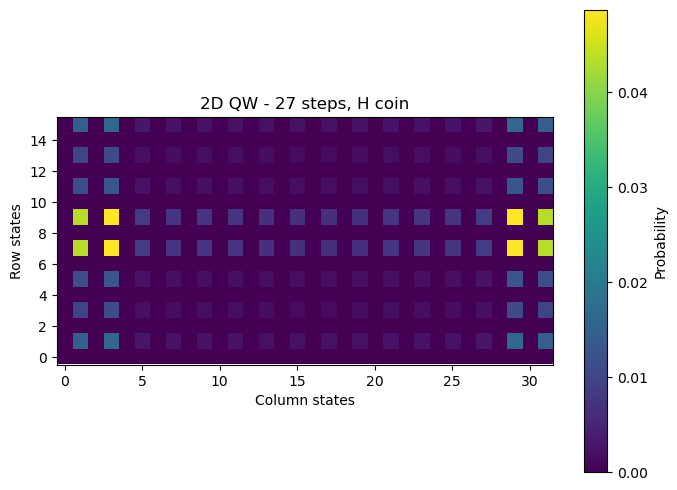

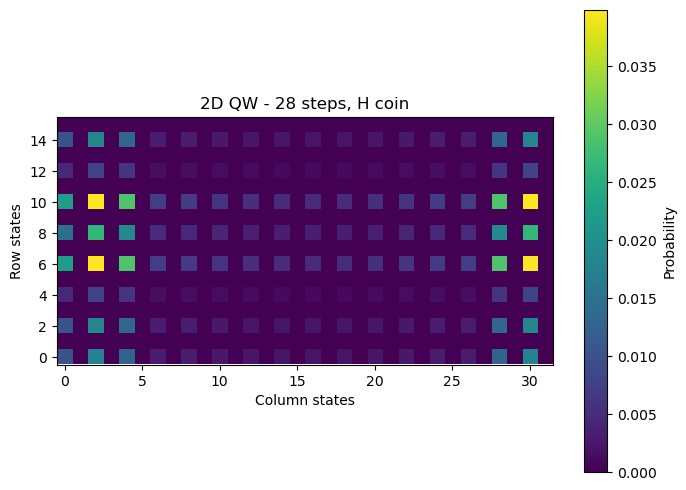

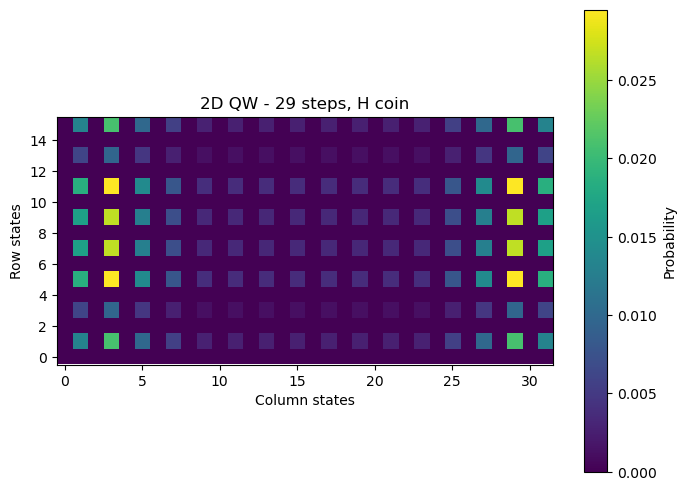

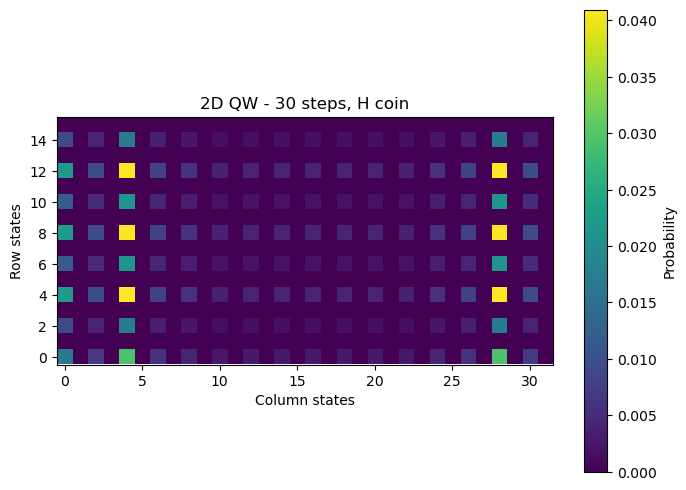

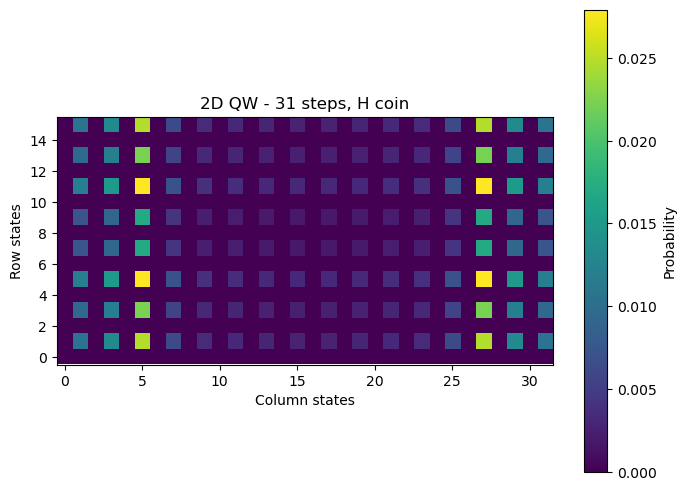

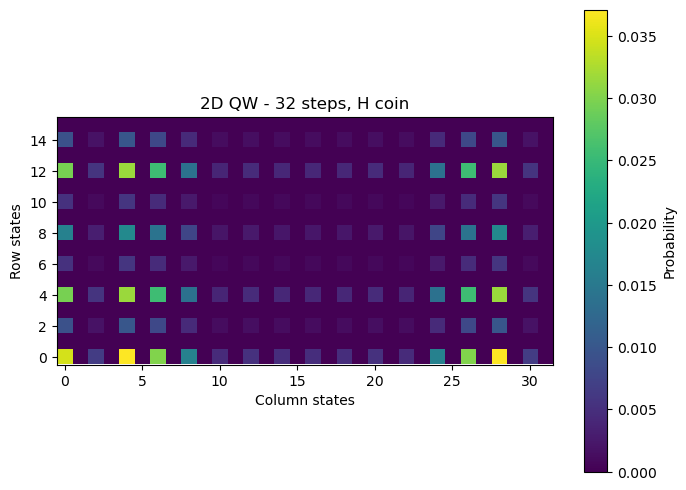

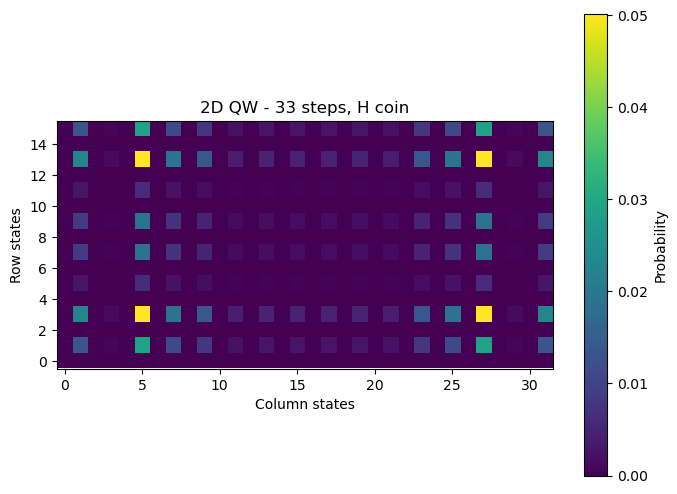

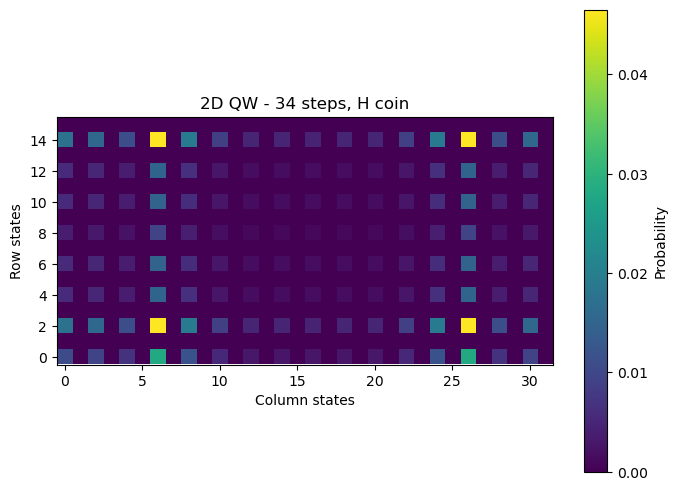

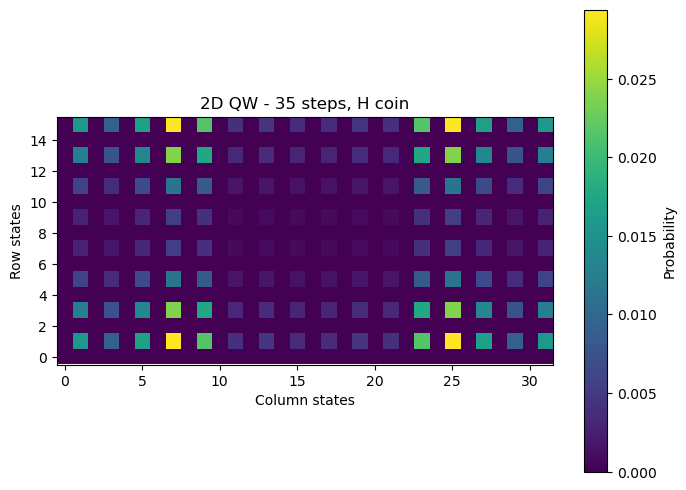

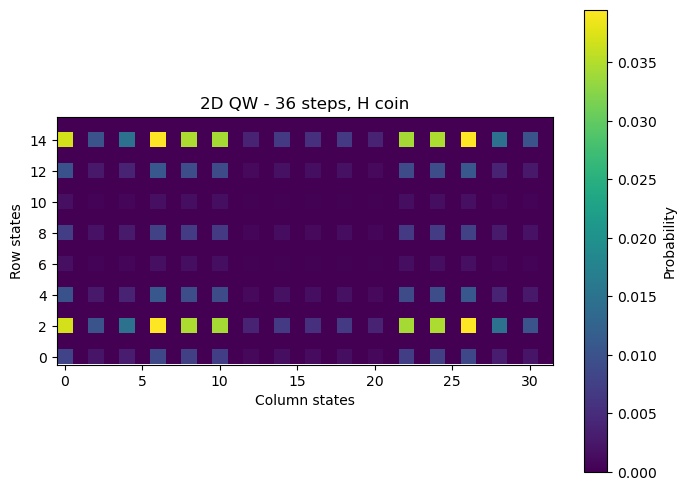

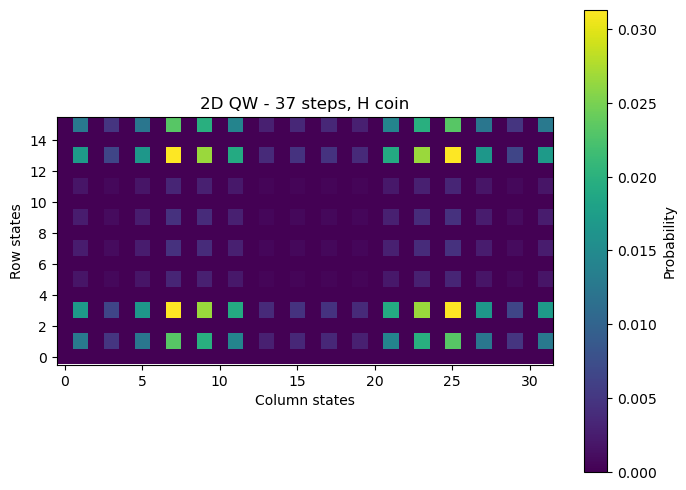

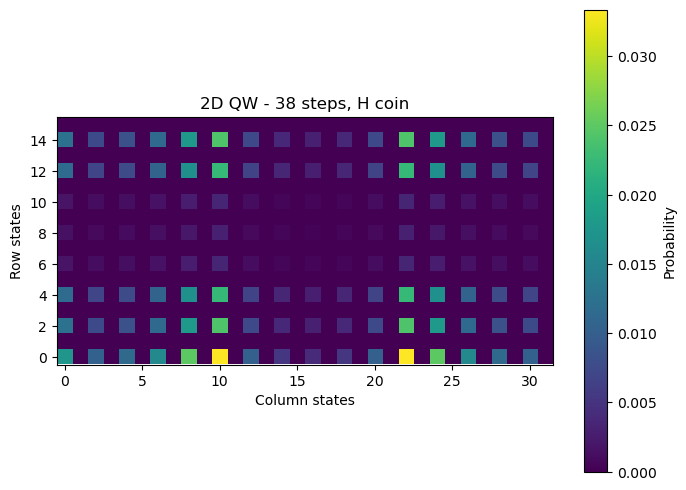

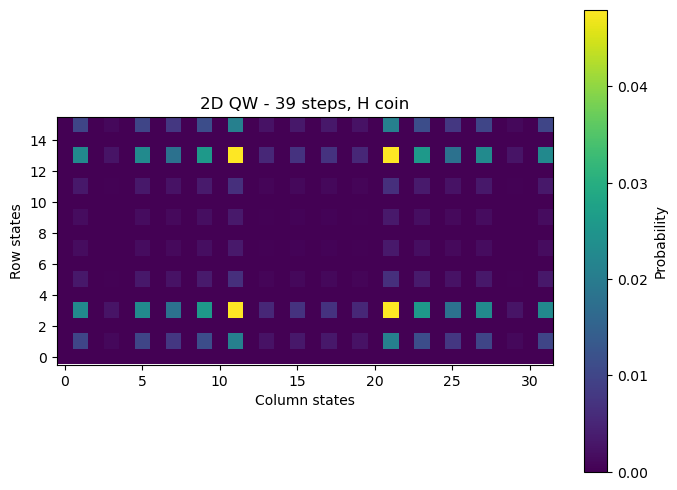

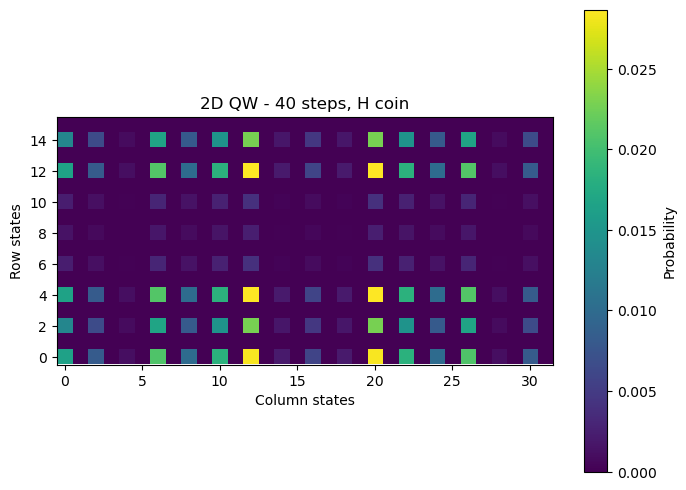

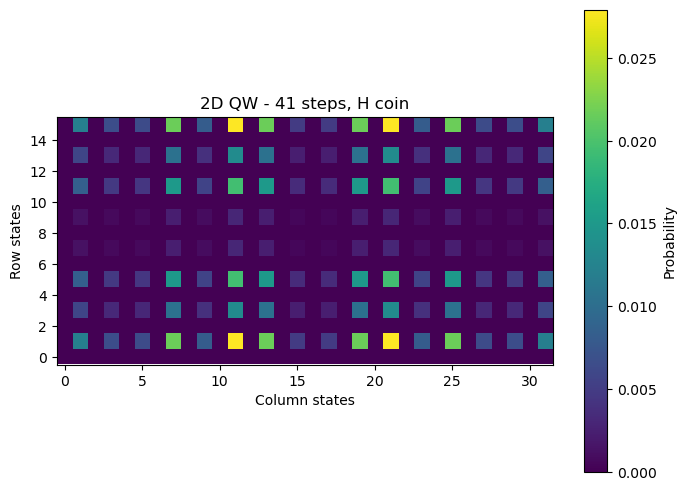

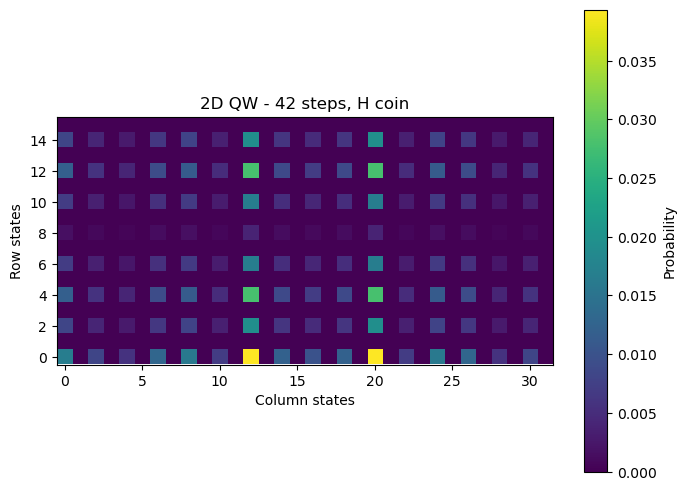

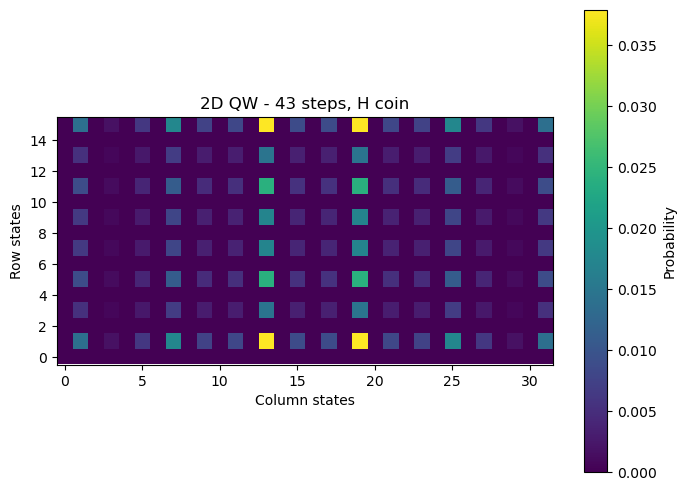

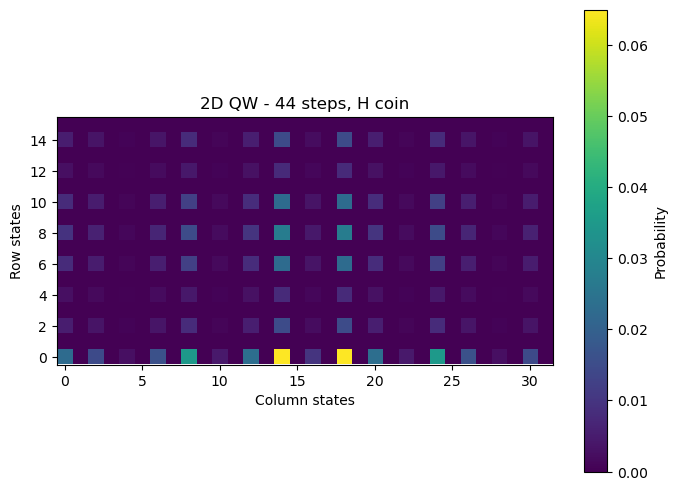

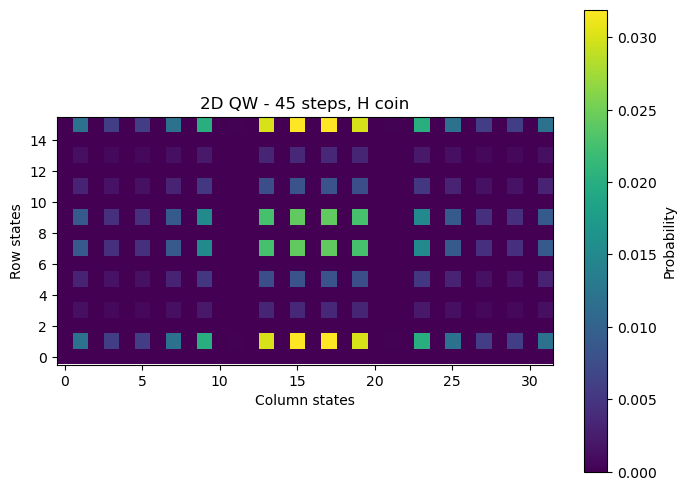

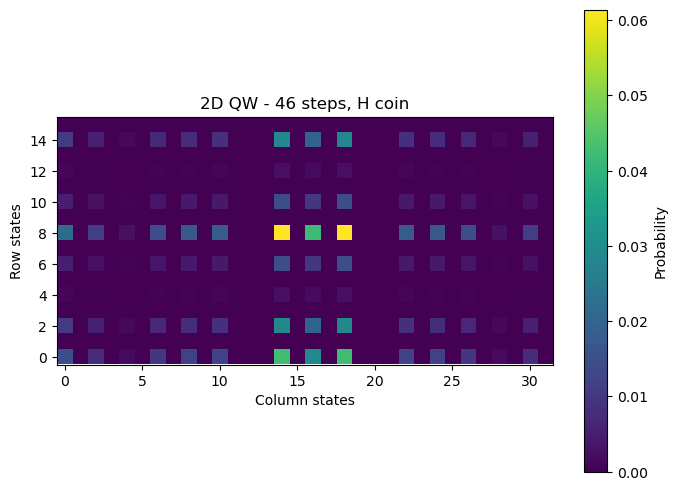

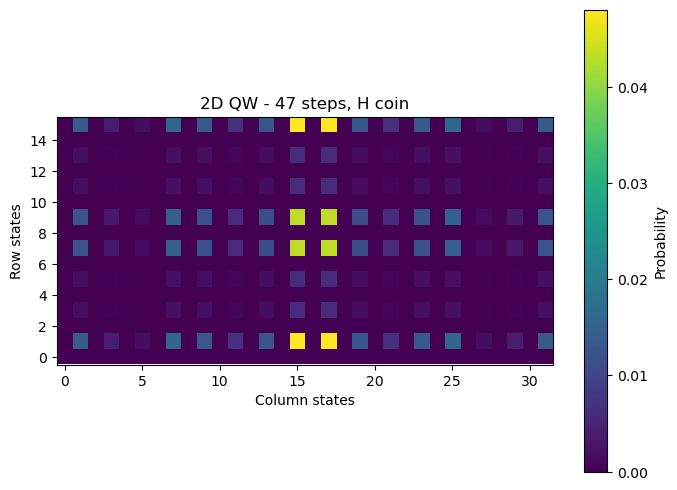

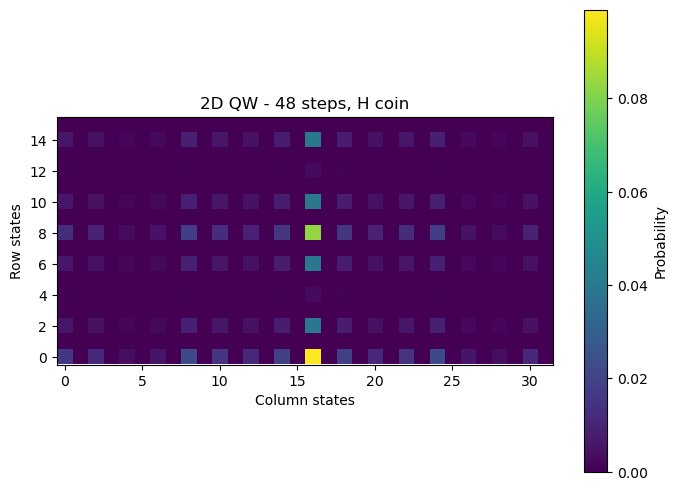

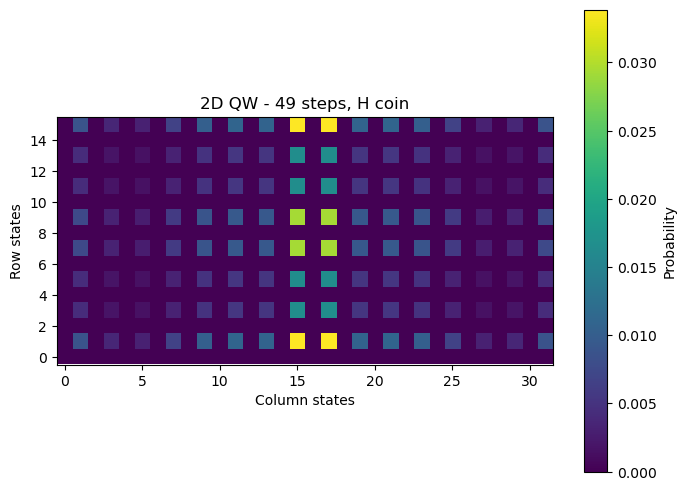

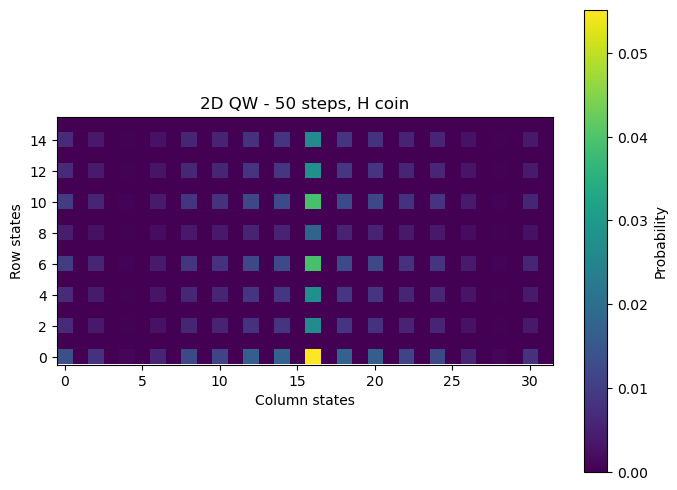

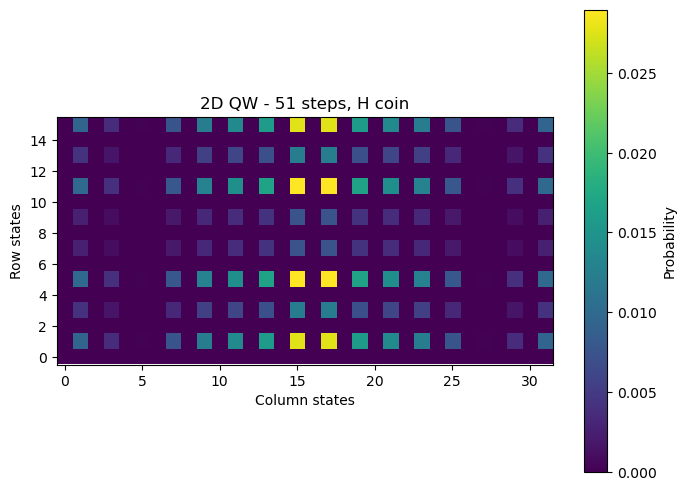

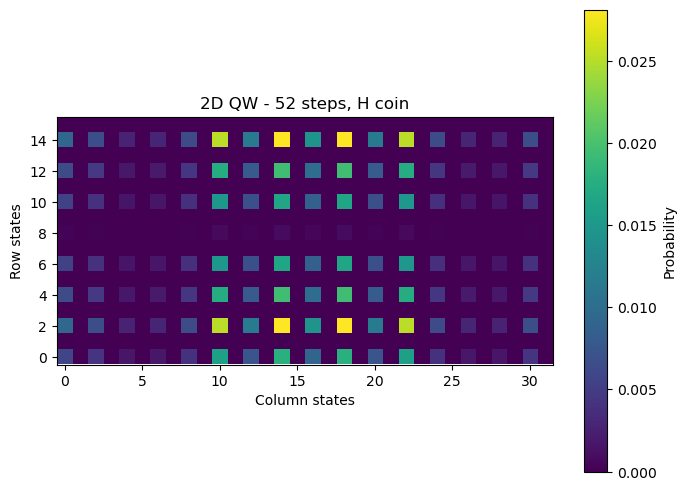

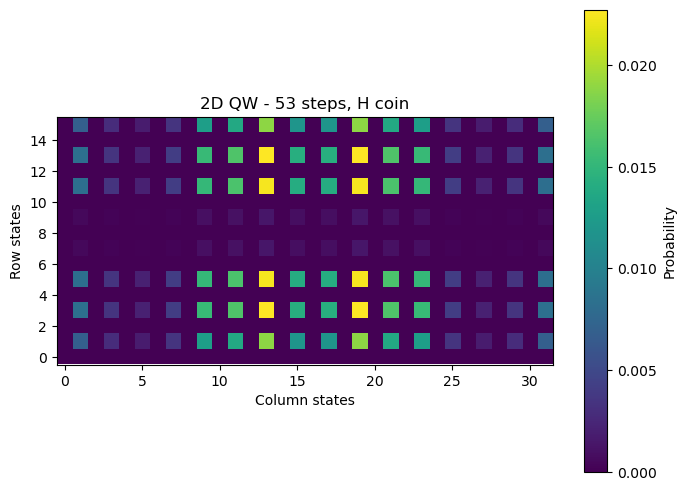

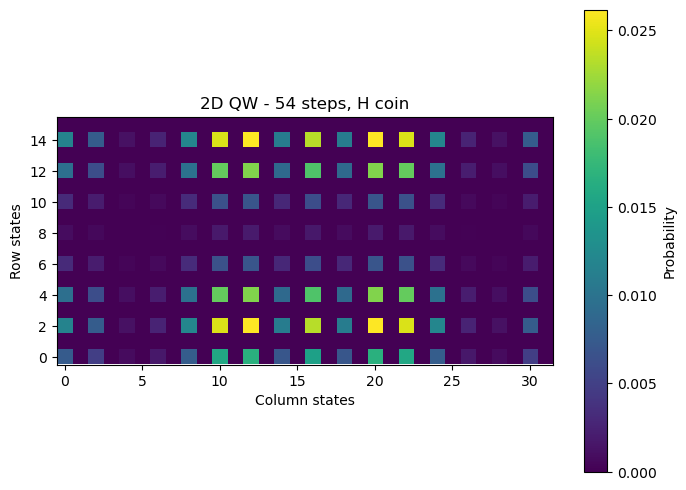

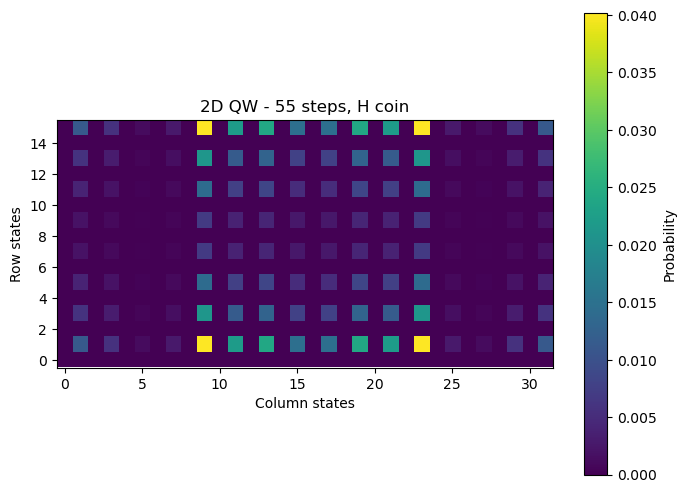

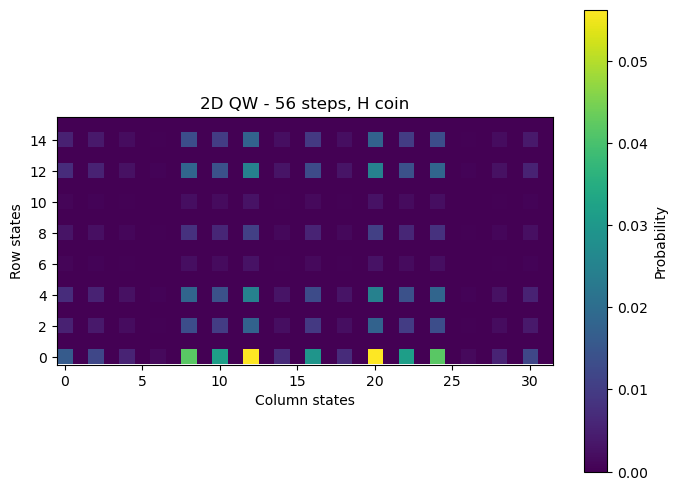

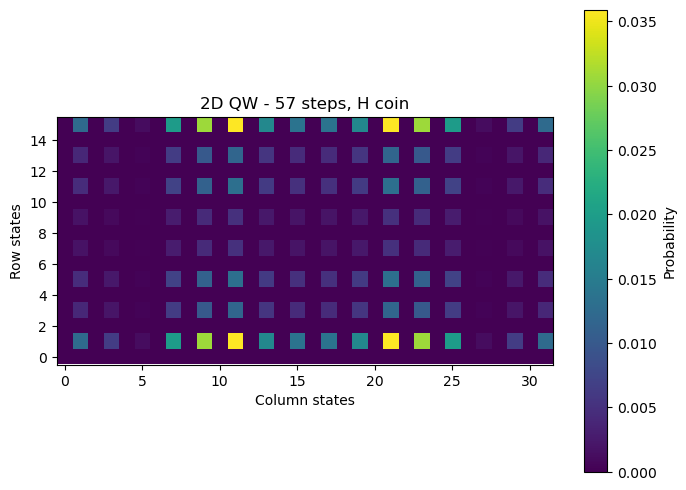

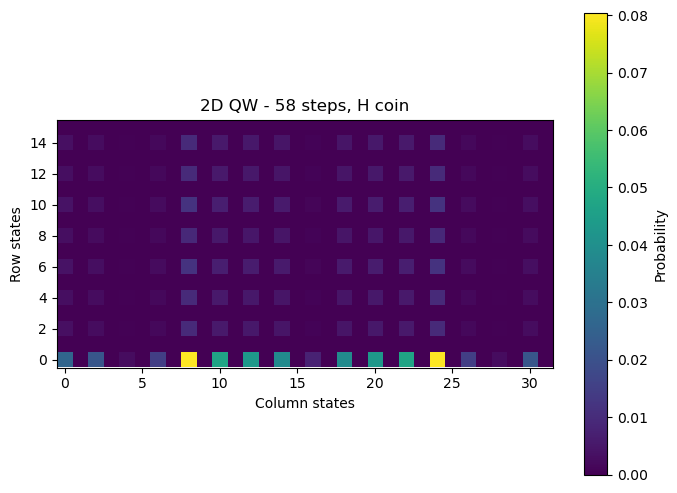

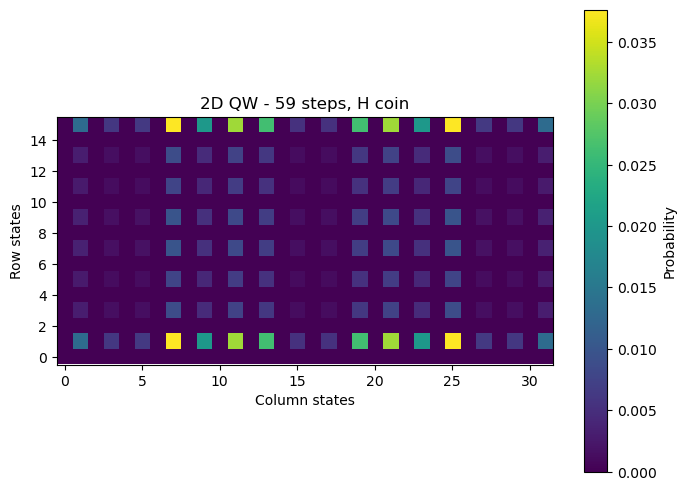

'\nfor i in range(10):\n    plot2d_coin(10+i, "H")\n\nfor i in range(10):\n    plot2d_coin(10+i, "F")\n\nfor i in range(10):\n    plot2d_coin(10+i, "G")\n'

In [36]:
N = 4
M = 5

COIN_REG = ["coin1", "coin2"]
ROW_REG = ["row%d"%i for i in range(N)]
COL_REG = ["col%d"%i for i in range(M)]

dev = pl.device("default.qubit", wires = COIN_REG + COL_REG + ROW_REG)

grover_coin = np.array([[-1, 1, 1, 1],
                        [1, -1, 1, 1],
                        [1, 1, -1, 1],
                        [1, 1, 1, -1]]) / 2

fourier_coin = np.array([[1, 1, 1, 1],
                        [1, 1j, -1, -1j],
                        [1, -1, 1, -1],
                        [1, -1j, -1, 1j]]) / 2

control_z = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, -1]])

def init_coin(theta, phi, wire):
  # returns cos(theta)|0> + e^(-i*pi/2)sin(theta)|1>
  pl.RX(2 * theta, wires=wire)
  # returns cos(theta)|0> + e^(i*phi)sin(theta)|1>
  pl.PhaseShift(phi + (np.pi/2), wires=wire)
  return

# scenarios below are denoted by the first letter of each respective coin
@pl.qnode(dev)
def quantum_walk_2d_coins(T, scenario):
    initialise_register(COL_REG)
    initialise_register(ROW_REG)
    if scenario == "H":
        init_coin(np.pi/4, np.pi/2, COIN_REG[0])
        init_coin(np.pi/4, np.pi/2, COIN_REG[1])
        for i in range(T):
            pl.Hadamard(wires=COIN_REG[0])
            pl.Hadamard(wires=COIN_REG[1])
            CCU_down()
            CCU_up()
            CCU_left()
            CCU_right()
    elif scenario == "F":
        init_coin(np.pi/4, 0, COIN_REG[0])
        init_coin(np.pi/4, -np.pi/4, COIN_REG[1])
        pl.QubitUnitary(control_z, wires=COIN_REG)
        for i in range(T):
            pl.QubitUnitary(fourier_coin, wires=COIN_REG)
            CCU_down()
            CCU_up()
            CCU_left()
            CCU_right()
    elif scenario == "G":
        for i in range(len(COIN_REG)):
            pl.PauliX(wires=COIN_REG[i])
            pl.Hadamard(wires=COIN_REG[i])
        for i in range(T):
            pl.QubitUnitary(grover_coin, wires=COIN_REG)
            CCU_down()
            CCU_up()
            CCU_left()
            CCU_right()
    return pl.state()


def plot2d_coin(T, scenario):
    states = quantum_walk_2d_coins(T, scenario)
    prob = np.abs(states) ** 2

    # factorise out coin qubits
    prob2 = np.split(prob, 2 ** 2)
    
    # sum of factorised prob states
    probabilities = [sum(row[i] for row in prob2) for i in range(len(prob2[0]))]

    # create grid
    probability_grid = np.reshape(probabilities, (2 ** N, 2 ** M))
    
    # reverse bit string to int list for each register
    row_states = find_states(ROW_REG)
    col_states = find_states(COL_REG)

    # reorder probability grid according to above
    for i in range(len(col_states)):
        for j in range(len(row_states)):
            x_idx = row_states[j]
            y_idx = col_states[i]
            probability_grid[x_idx, y_idx] = probabilities[i * len(row_states) + j]

    plt.figure(figsize=(8, 6))
    plt.imshow(probability_grid, origin='lower')
    plt.colorbar(label="Probability")
    plt.ylabel('Row states')
    plt.xlabel('Column states')
    plt.title("2D QW - %d steps, %s coin" % (T, scenario))
    plt.show()


print("Hadamard coin circuit")
print(pl.draw(quantum_walk_2d_coins)(2, "H"))
print("Fourier coin circuit")
print(pl.draw(quantum_walk_2d_coins)(2, "F"))
print("Grover coin circuit")
print(pl.draw(quantum_walk_2d_coins)(2, "G"))


#plot2d_coin(1000, "H")
#plot2d_coin(1000, "F")
#plot2d_coin(1000, "G")

for i in range(50):
    if i % 1 == 0:
        plot2d_coin(10+i, "H")

"""
for i in range(10):
    plot2d_coin(10+i, "H")

for i in range(10):
    plot2d_coin(10+i, "F")

for i in range(10):
    plot2d_coin(10+i, "G")
"""




**Why do results differ?**

The Hadamard coin matrix is 

$$
\hat{H}_4 = \frac{1}{2} \begin{pmatrix}
1 &  1 &  1 &  1 \\
1 &  -1 & 1 & -1 \\
1 &  1 &  -1 & -1 \\
1 &  -1 & -1 & 1
\end{pmatrix}
$$

Results differ due to the fact that the nature of each unitary coin operation being applied is different.

The starting state for the hadamard coin scenario above simulates the symmetrical distribution that was observed in 1D but along two dimensions, causing four distinct peaks to appear at most timesteps. The peak for the states with an imaginary amplitude from the $\ket{1}$ coin state constuctively interfere from each register, and the same happpens for the other peak which arises for the states with a real amplitude from the $\ket{1}$ coin state. This is analagous to what was seen earlier when the initial coin state started in the same superposition state for the 1D qubit case. As the number of timesteps increase, the peaks all exhibit a shift in each respective direction according to the four subspaces that the coin now covers (i.e  $\ket{00}$, $\ket{01}$, $\ket{10}$ and $\ket{11}$). Each peak then undergoes its own ballistic shift as this is a superposition of all possible coin states, meaning we are simulataneously maximising both registers ($\ket{11}$), minimising both register states ($\ket{00}$), maximising the row states and minimizing the column states ($\ket{10}$) and vice versa ($\ket{01}$). Again due to periodic boundary conditions, the peaks move until the boundaries and then converge at the centre state to repeat the same cycle again for increased timesteps.

The fourier coin matrix causes each state in the coin qubit to undergo a quantum fourier transformation. The structure of the matrix confirms this as each row of the matrix applies transform to each subspace of the coin register, for example for the $\ket{01} = \ket{1}$ state gives the second row:

$$ FT_N\ket{j} = \frac{1}{\sqrt{2}} \sum_{k = 0}^{N - 1}e^{(2 \pi i)jk / 2^N}\ket{k}  $$
$$ FT_4\ket{1} = \frac{1}{\sqrt{2}} \sum_{k = 0}^{3}e^{(2 \pi i)k / 2^N}\ket{k} = \frac{1}{2} (\ket{0} + i\ket{1} - \ket{2} - i\ket{3})$$

The resulting state is then passed through the movement operations for column states (i.e. left/right) and row qubits (i.e. up/down). After another fourier transform as this is a unitary matrix, the state returns to the initial superposition. However, we prepared the initial state of the coin qubit with phase factors present on $\ket{01}$ and $\ket{11}$ states which causes the state to become entangled. The first application of the fourier transform on the prepares state then transforms the coin qubit as follows:

$$ \frac{1}{2} \begin{pmatrix}
1 &  1 &  1 &  1 \\
1 &  i & -1 & -i \\
1 & -1 &  1 & -1 \\
1 & -i & -1 &  i
\end{pmatrix} 
\cdot 
\frac{1}{2} \begin{pmatrix} 1 \\ e^{-i\pi/4} \\ 1 \\ -e^{-i\pi/4} \end{pmatrix} = 
\frac{1}{4} \begin{pmatrix} 2 \\ 2ie^{-i\pi/4} \\ 2 \\ -2ie^{-i\pi/4} \end{pmatrix} =
\frac{1}{2} \begin{pmatrix} 1 \\ e^{i\pi/4} \\ 1 \\ -e^{i\pi/4} \end{pmatrix}
$$

Therefore, the fourier coin changes only the sign in exponent of complex the phase factors with each application, meaning that the $\ket{01}$ and $\ket{11}$ states remain on the complex plane whereas the $\ket{10}$ and $\ket{00}$ states remain on the complex plane. As a result of this, these two subspaces (i.e. {${\ket{01}}$ , ${\ket{11}}$} and {${\ket{00}}$ , ${\ket{10}}$}) now evolve seperately throughout the statespace and do not interfere with one another. The result of this a symmetric distribution as was seen in the 1D case, with two distinct peaks reflecting the probabilities of finding the particle according to the time evolution on the real and complex planes. The result of this is a distribution that spreads across the state space relatively quickly, allowing the particle to explore multiple possible states at any timestep. This is supported by the fact that, due to the phase factors introduced in preparing the coin state, peaks explore both column and row states at an even rate. The fourier coin therefore creates a superposition of all the possible states within the statespace itself.

The grover coin focuses on amplifying the amplitude of the marked state. Here we notice that the coin comprises of the lower triangular and upper triangular matrices consisting of ones, with the negative idenitity across the diagonal. This is the expected form of the grover operator:  $ G = \ket{D}\bra{D} - \mathbb{I}$ where D is the diagonal state of the coin space. The state is given as a superposition over all four subspaces of the coin register in the computational basis. As the register states are related to these states via tensor product, our register state-space is also partitioned into four. The state is initially prepared to have a $-1$ phase on $\ket{01}$ and $\ket{10}$, however, an application of the grover coin causes this to switch and makes the $\ket{00}$ and $\ket{11}$ states negative. Each odd timestep then must cause the quantum random walk to make the coin qubits $\ket{00}$ and $\ket{11}$ negative, and even timesteps cause $\ket{01}$ and $\ket{10}$ to be negative. As a result of this, each odd timestep causes the distribution to constructively interfere within the $\ket{01}$ and $\ket{10}$ coin subspaces and destructively interfere within the $\ket{00}$ and $\ket{11}$ coin subspaces. The opposite to this occurs on each even timestep. However, as the each timestep operator is applied we still have the effect of shifting the distribution due to the $U^+$ and $U^-$ operators being triggered an uneven amount in each direction. The result is a distribution that spreads outward with increasing $T$, being pulled in four different directions (due to the four different subspaces we prepared the coin in) with the peak splitting into a ripple which propagates outward through the state-space. Due to periodic boundary conditions, once the ripple of probabilities reaches the edge of the state-space it cannot shift any further and so the peak reappears in the middle state for each register and the process begins again. Physically speaking, the particle is continually oscillating back and forth between certain positions within each row and column, but due to the superposition the particle does not remain oscillating over a particular subset of states. Instead the particle slowly explores the statespace, oscillating between states before moving on to the next state, where it will oscillate again and repeat.

